# 1️⃣ **Analysis of polymers sales**

**Task**: train a few base algorithms

**Models:**
- `SMA ETNA`
- `Propthen ETNA`
- `Catboost ETNA`
- `Propthen`


✅ The following will be implemented:
- all additional conditions

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import copy
from sklearn.preprocessing import LabelEncoder
from  sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings(action="ignore", message="Torchmetrics v0.9")

In [ ]:
!pip install etna

In [ ]:
from etna.datasets.tsdataset import TSDataset

/usr/local/lib/python3.10/dist-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("etna[classification] is not available, to install it, run `pip install etna[classification]`")
/usr/local/lib/python3.10/dist-packages/etna/settings.py:71: UserWarning: etna[auto] is not available, to install it, run `pip install etna[auto]`
  warnings.warn("etna[auto] is not available, to install it, run `pip install etna[auto]`")
/usr/loc

In [ ]:
from etna.models import ProphetModel
from etna.metrics import MAE, MSE, MAPE
from etna.analysis import plot_forecast

In [ ]:
from etna.models import MovingAverageModel, SeasonalMovingAverageModel

In [ ]:
import random
random.seed(42) # фиксируем воспроизводимость
%matplotlib inline

In [ ]:
from etna.analysis.outliers import (
get_anomalies_median,
get_anomalies_density,
get_anomalies_hist)


In [ ]:
from etna.analysis import plot_anomalies
from etna.analysis import plot_anomalies_interactive
from etna.analysis import plot_imputation

In [ ]:
from etna.transforms import (
MeanTransform, LagTransform, MeanSegmentEncoderTransform,
SegmentEncoderTransform, HolidayTransform,
DateFlagsTransform, FourierTransform,
LogTransform, LinearTrendTransform, ChangePointsTrendTransform,
TheilSenTrendTransform, TrendTransform, MedianOutliersTransform,
DensityOutliersTransform, TimeSeriesImputerTransform,
StandardScalerTransform, MinMaxScalerTransform,
RobustScalerTransform, MaxAbsScalerTransform)

### Основные данные хранятся на диске

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Делаем краткий EDA данных

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data/sc2021_train_deals.csv', parse_dates=["month", "date"])

In [ ]:
data.head()

material_code  company_code    country           region  manager_code  \
0            134             0      Литва            Литва         12261   
1            197             0      Китай            Китай         16350   
2            794          2162  Казахстан  Атырауская обл.         10942   
3            134             0      Литва            Литва         12261   
4            133             0      Китай            Китай         17745   

       month material_lvl1_name material_lvl2_name material_lvl3_name  \
0 2018-01-01   Базовые полимеры                 ПЭ               ПЭНП   
1 2018-01-01   Базовые полимеры                 ПЭ               ПЭНП   
2 2018-01-01   Базовые полимеры                 ПП                 ПП   
3 2018-01-01   Базовые полимеры                 ПЭ               ПЭНП   
4 2018-01-01   Базовые полимеры                 ПЭ               ПЭНП   

  contract_type       date  volume  
0          Спот 2018-01-01    43.0  
1          Спот 2018-01-02    95.0  
2      Контракт 2018-01-02    57.0  
3          Спот 2018-01-02    21.0  
4          Спот 2018-01-02   150.0

In [ ]:
# временной диапазон выборки
min_date = data['date'].dt.strftime('%Y-%m-%d').min()
max_date = data['date'].dt.strftime('%Y-%m-%d').max()
min_date, max_date

('2018-01-01', '2020-07-31')

<Axes: xlabel='date'>

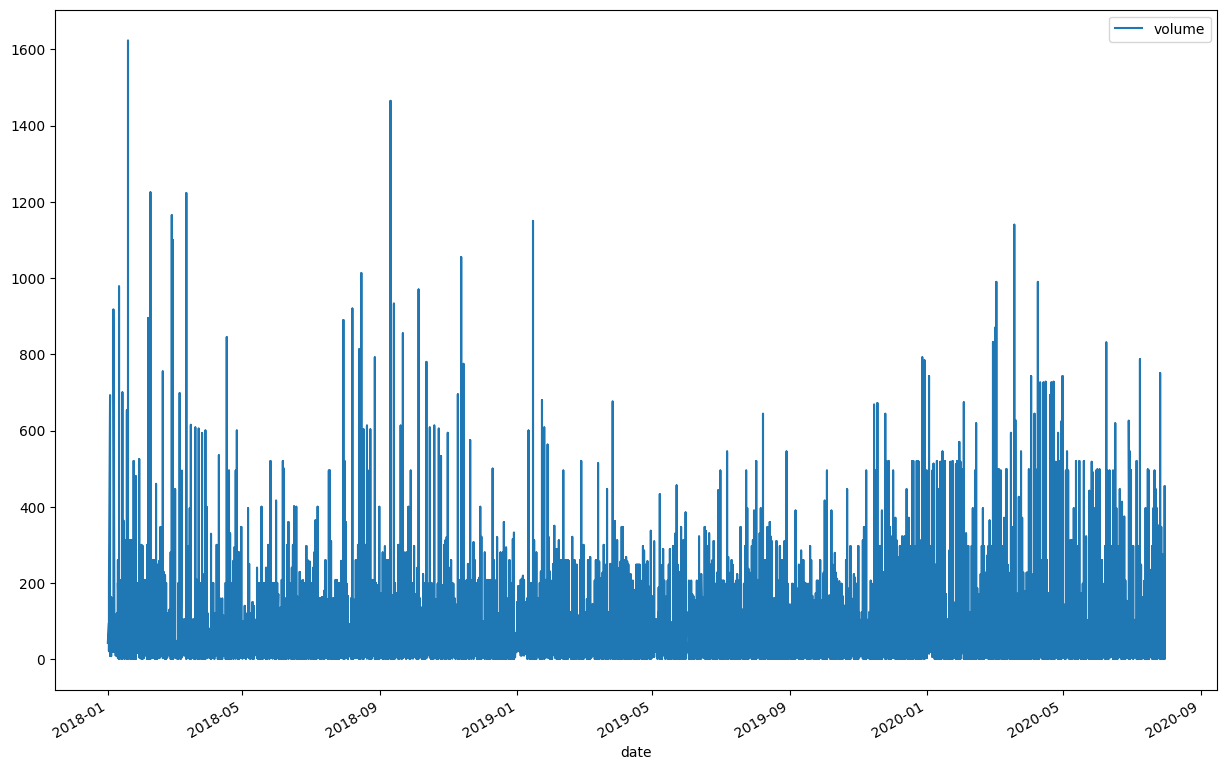

In [ ]:
data.plot(x = "date", y = "volume", figsize = (15,10))

## Разобъем общий график по продажам в зависимости от вида полимера для визуализации сегментов

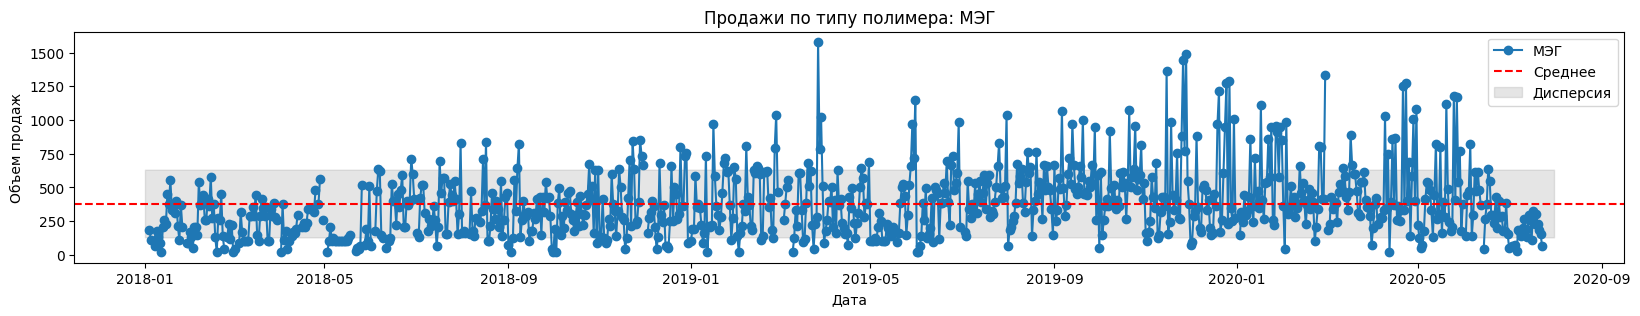

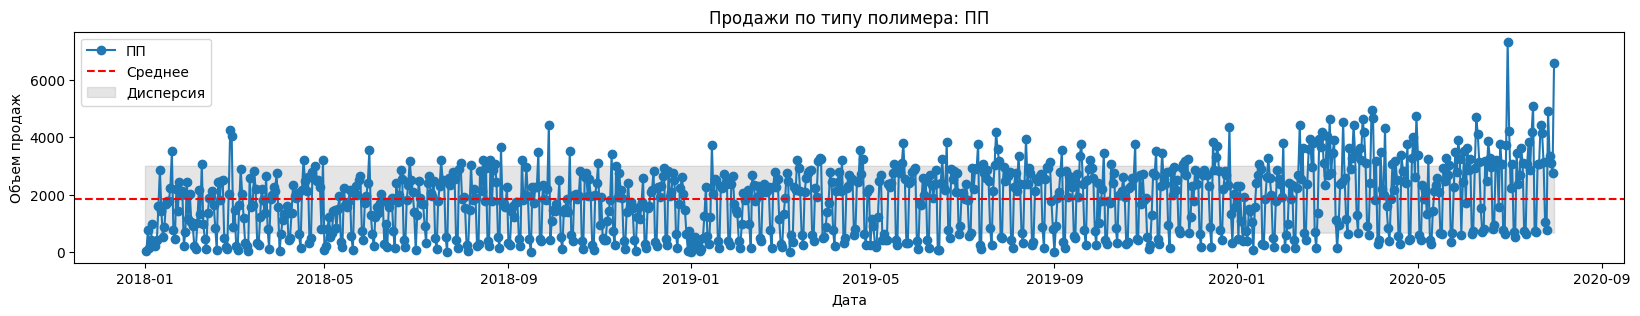

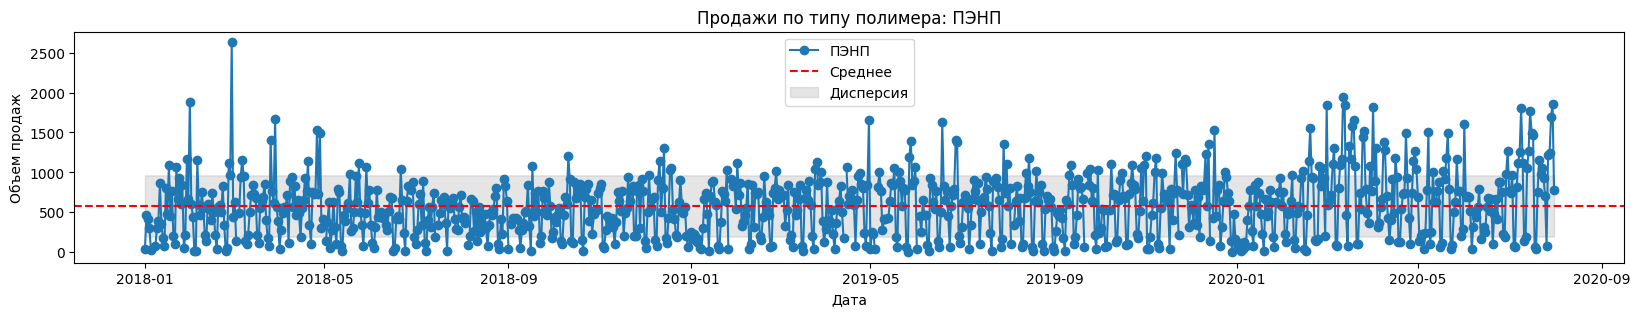

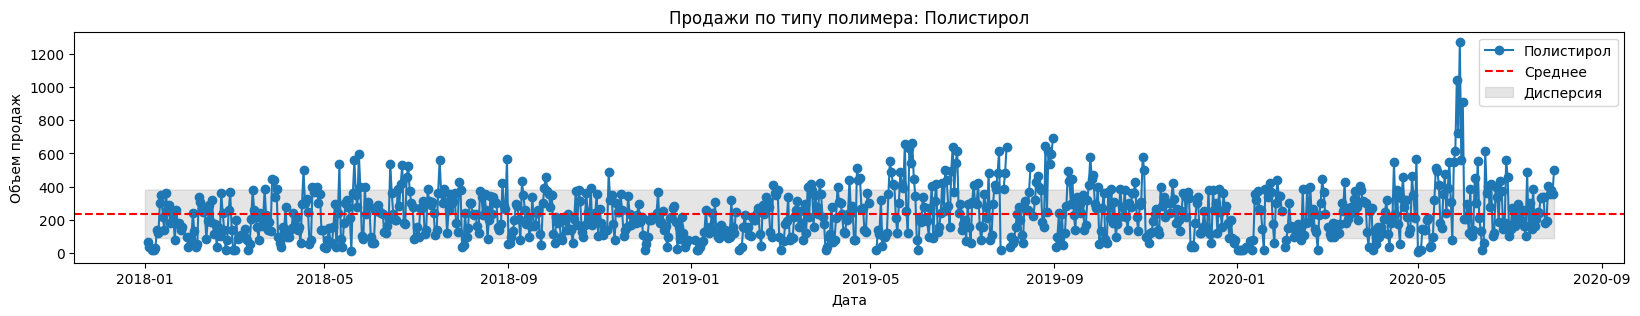

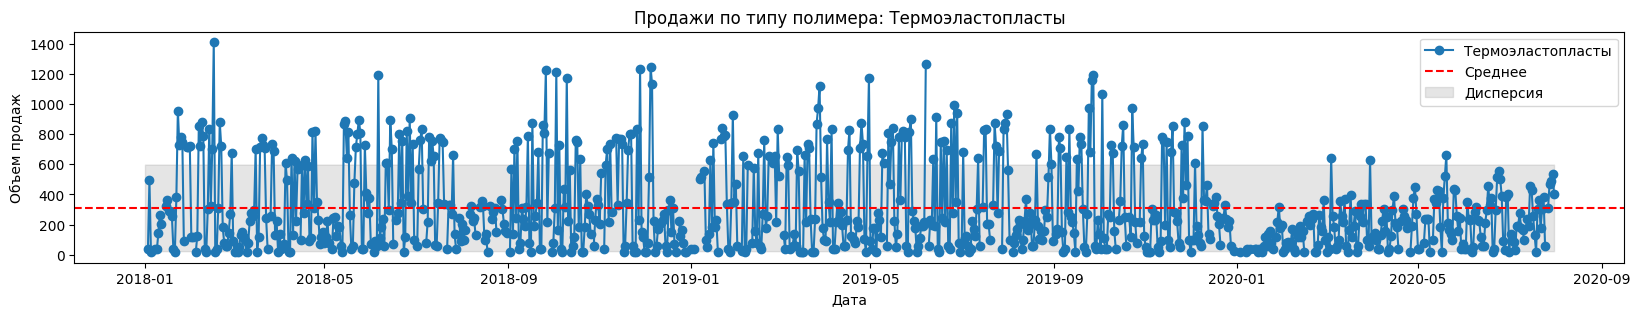

In [ ]:
grouped_data = data.groupby(["date", "material_lvl3_name"])["volume"].sum().reset_index()

# Преобразуем данные с помощью pivot
pivoted_data = grouped_data.pivot(index="date", columns="material_lvl3_name", values="volume")

for col in pivoted_data.columns:
    plt.figure(figsize=(20, 3))
    plt.plot(pivoted_data.index, pivoted_data[col], marker='o', label=col)
    plt.axhline(pivoted_data[col].mean(), color='r', linestyle='--', label='Среднее')
    plt.fill_between(pivoted_data.index, pivoted_data[col].mean() - pivoted_data[col].std(),
                     pivoted_data[col].mean() + pivoted_data[col].std(), color='gray', alpha=0.2, label='Дисперсия')
    plt.xlabel("Дата")
    plt.ylabel("Объем продаж")
    plt.title(f"Продажи по типу полимера: {col}")
    plt.legend()
    plt.show()

### Как видно МЭГ, полистирол и термоплатсы имеют потенциал по опредлению выбросов. У них также выше дисперсия данных

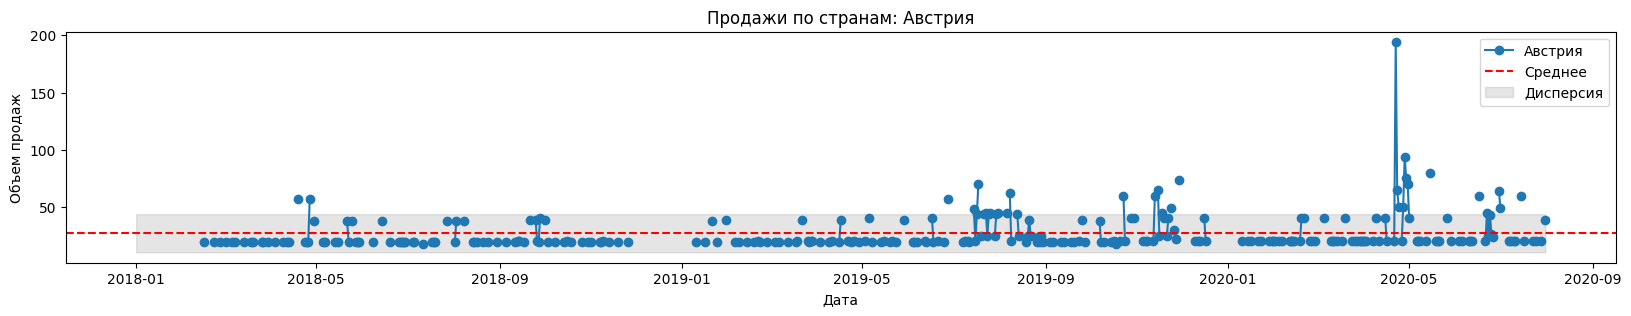

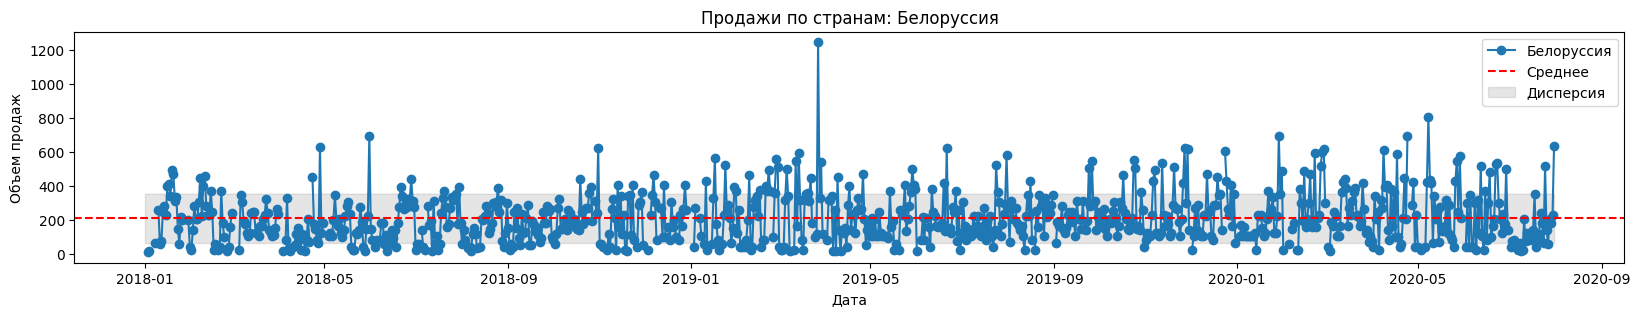

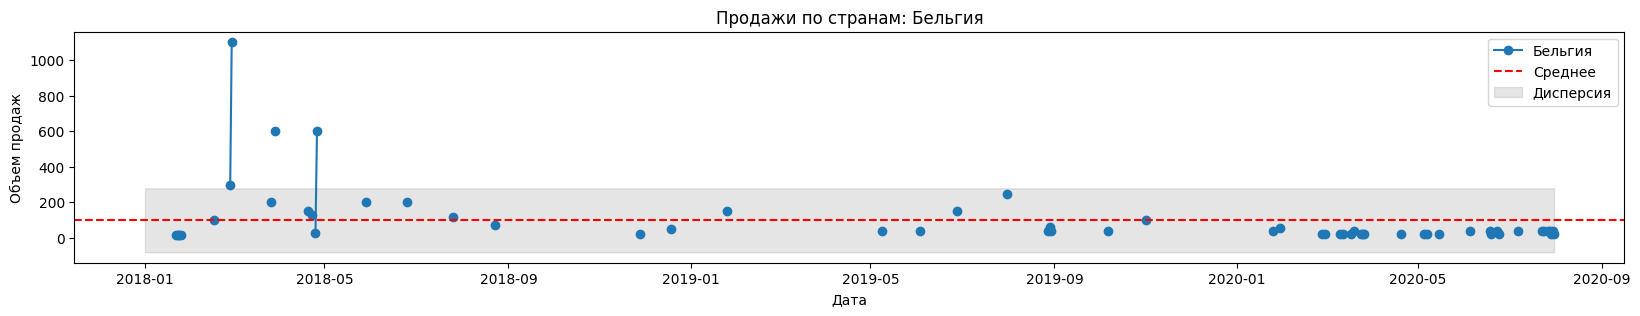

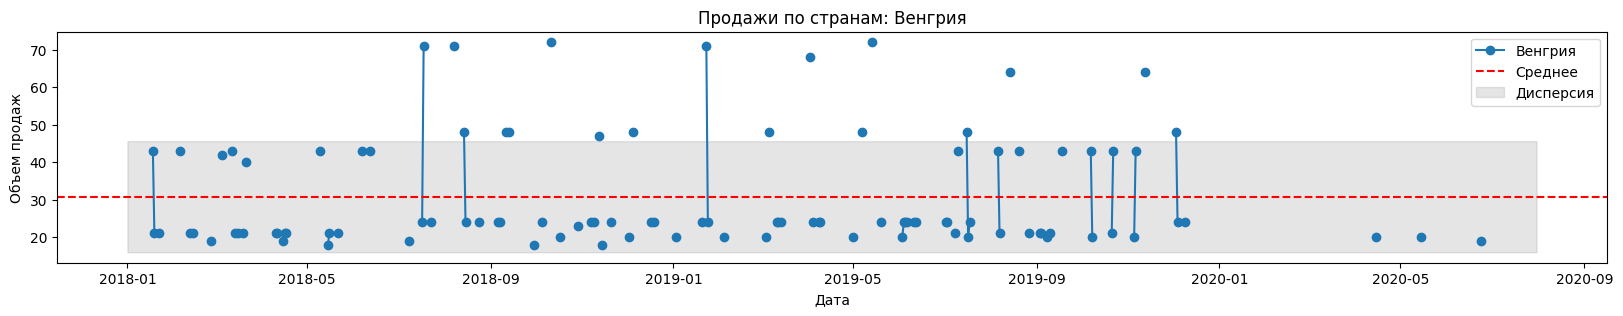

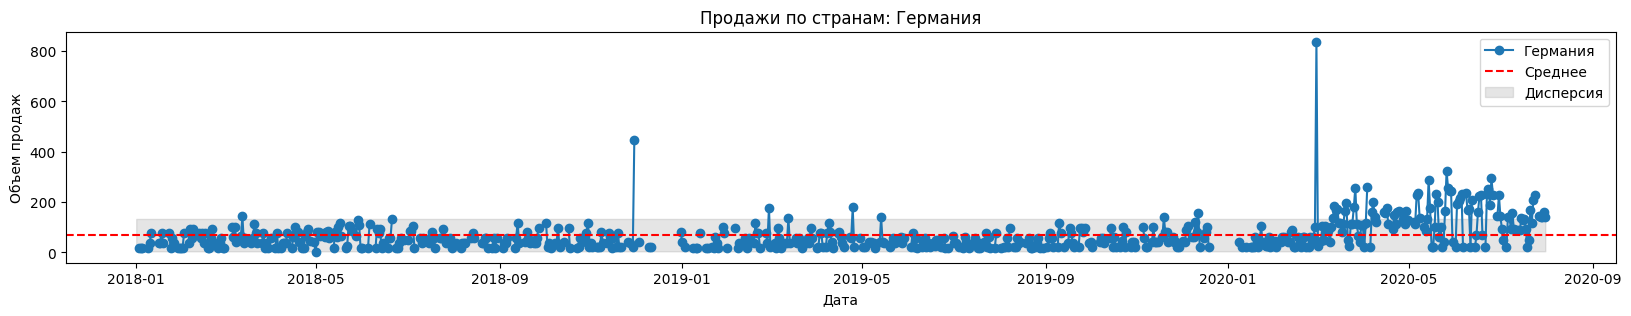

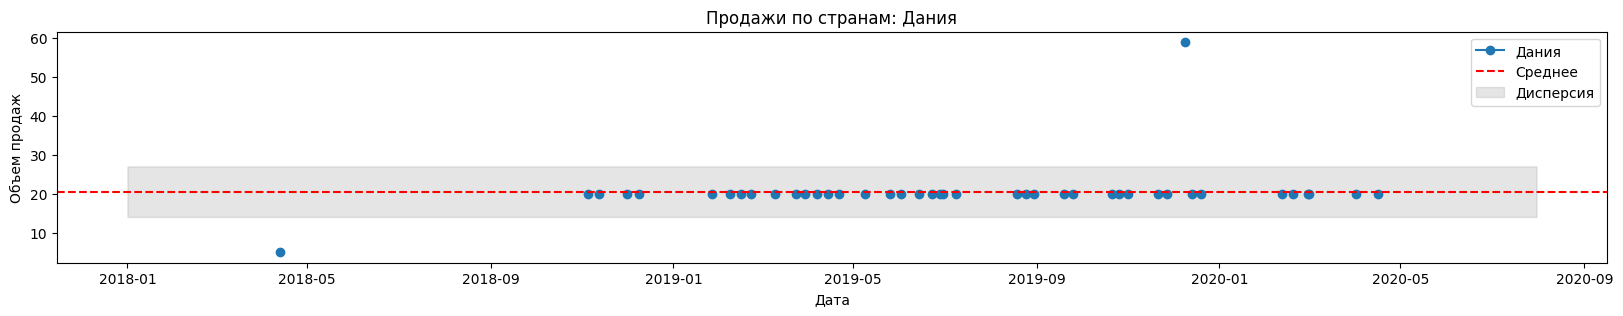

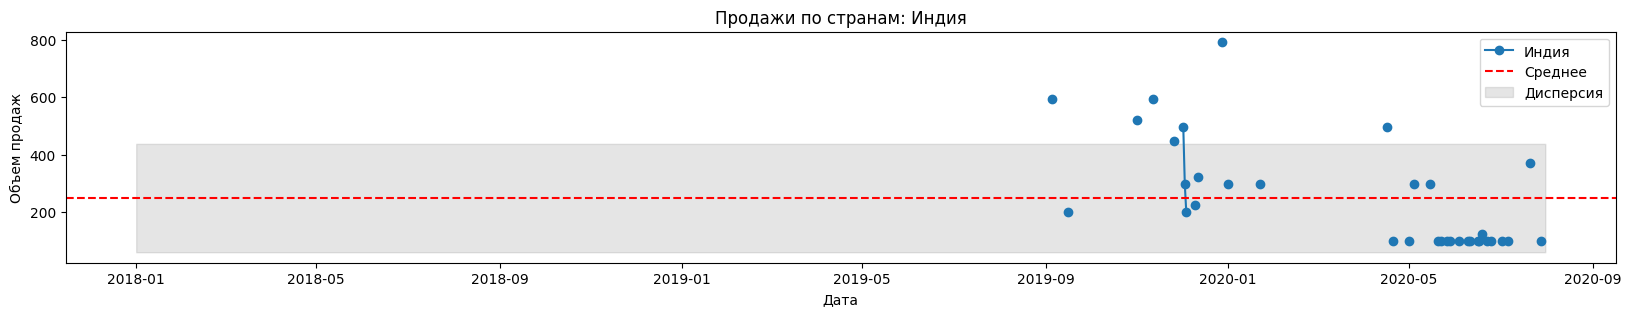

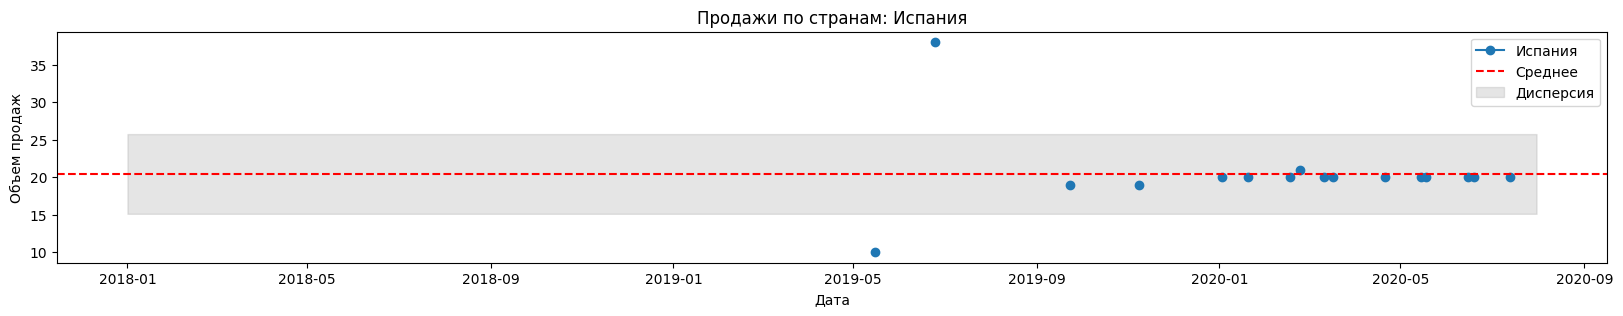

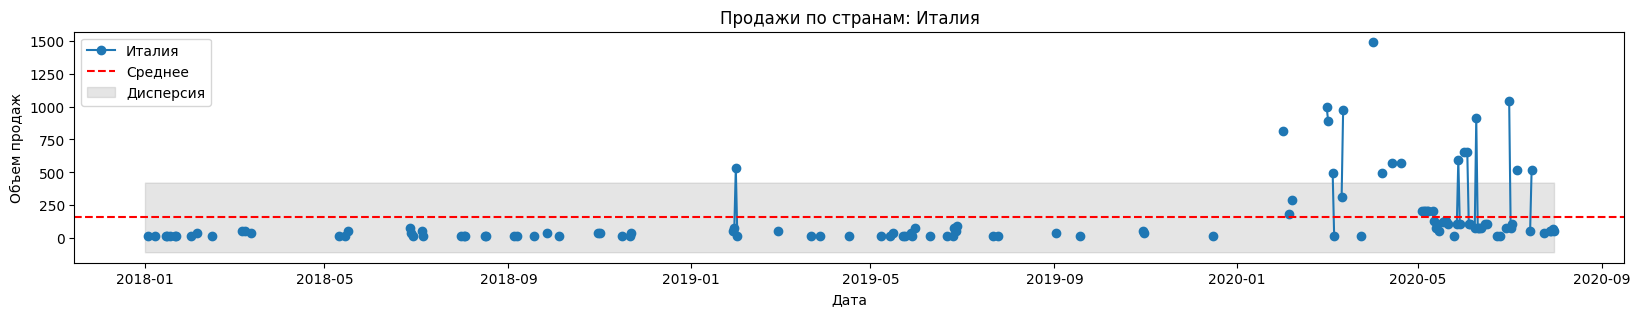

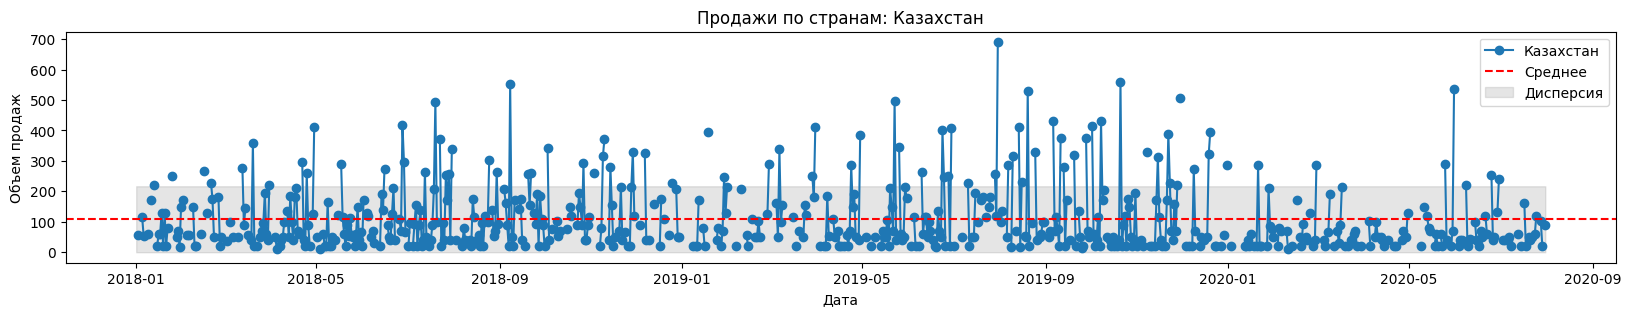

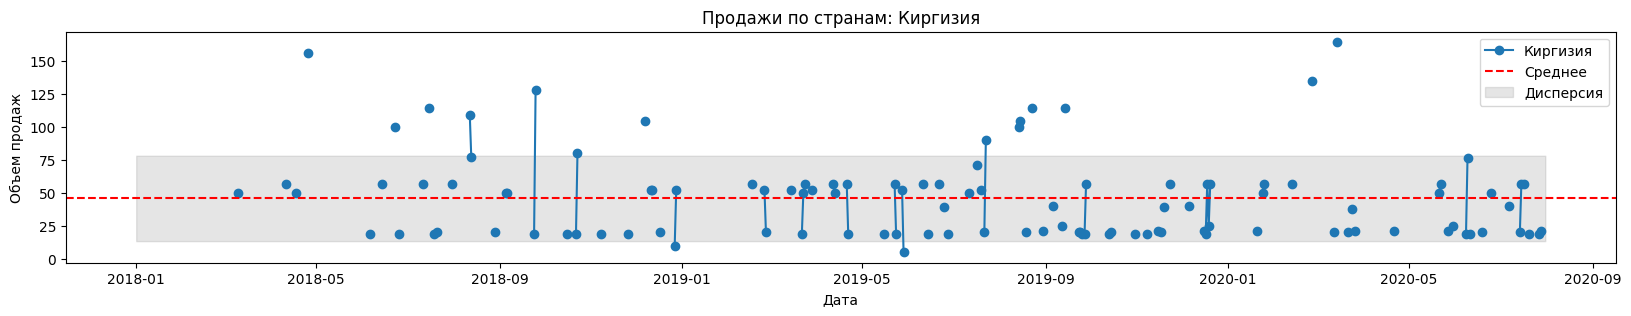

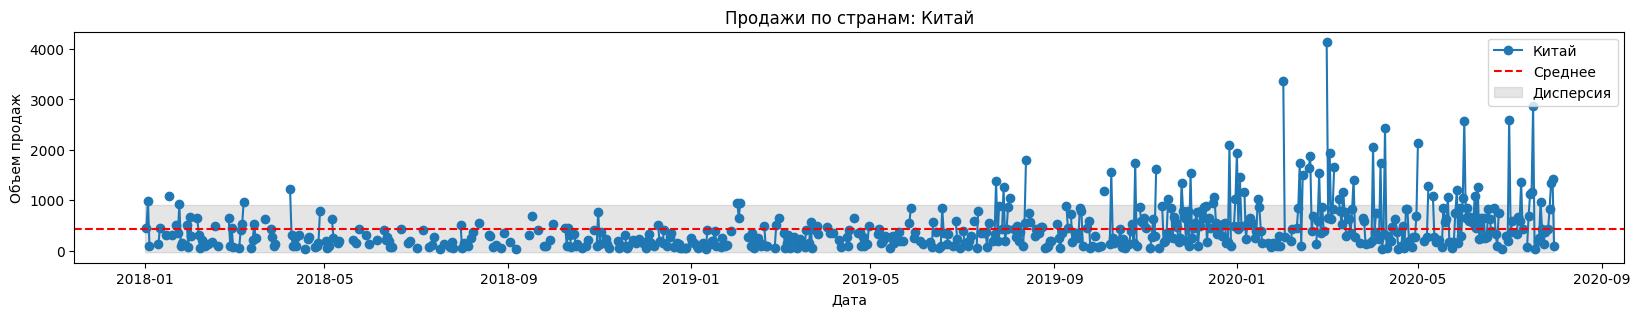

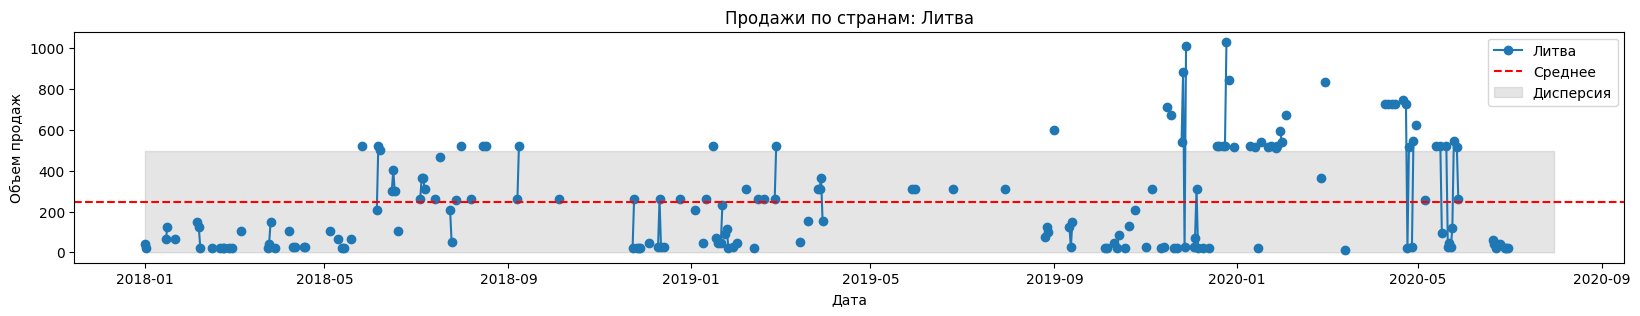

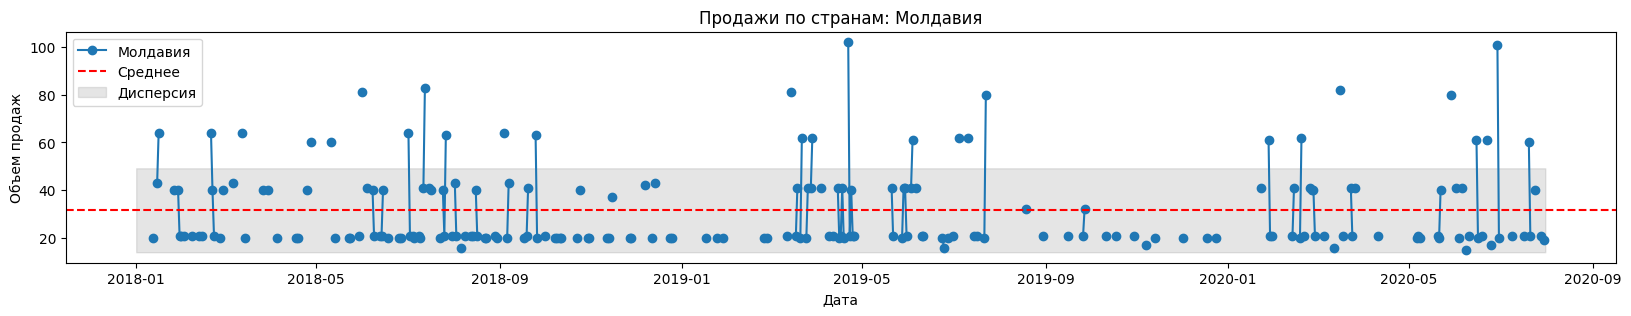

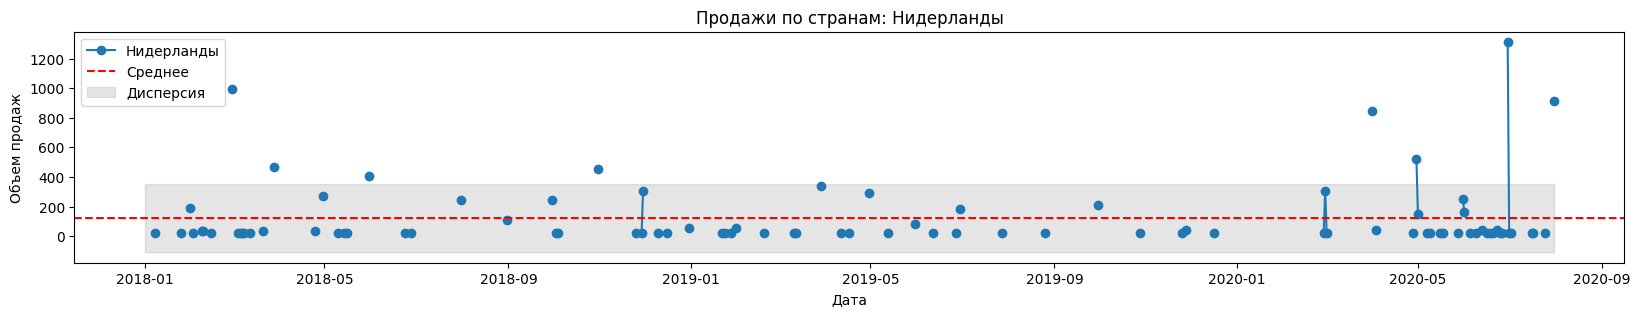

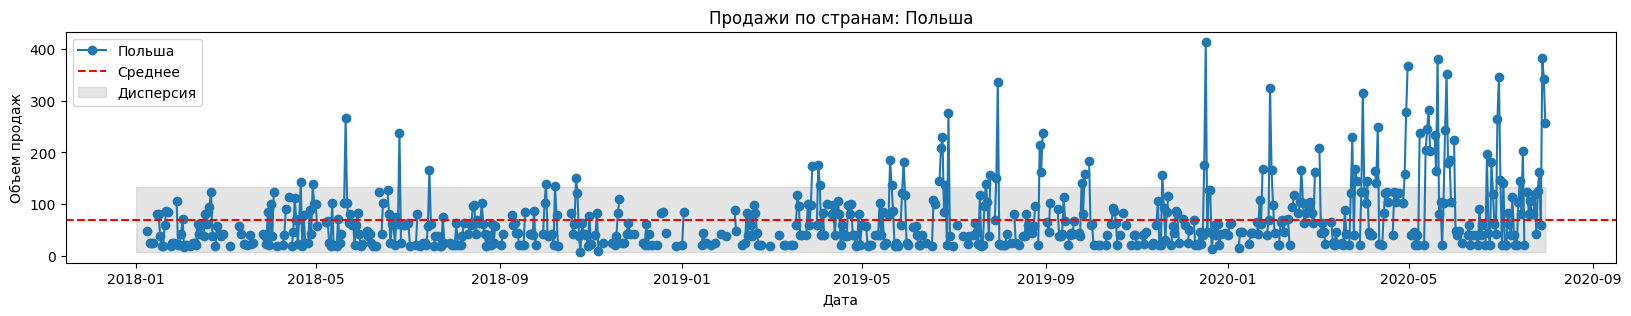

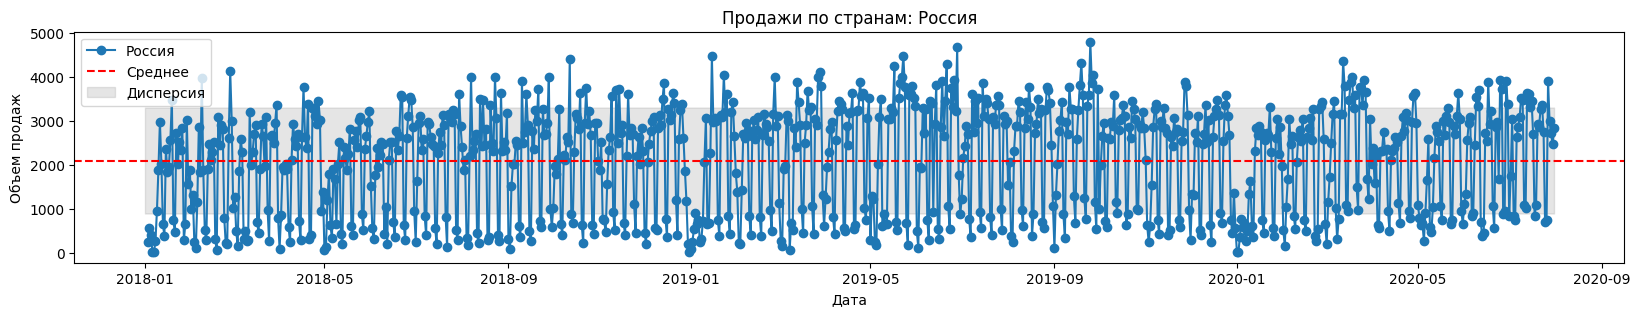

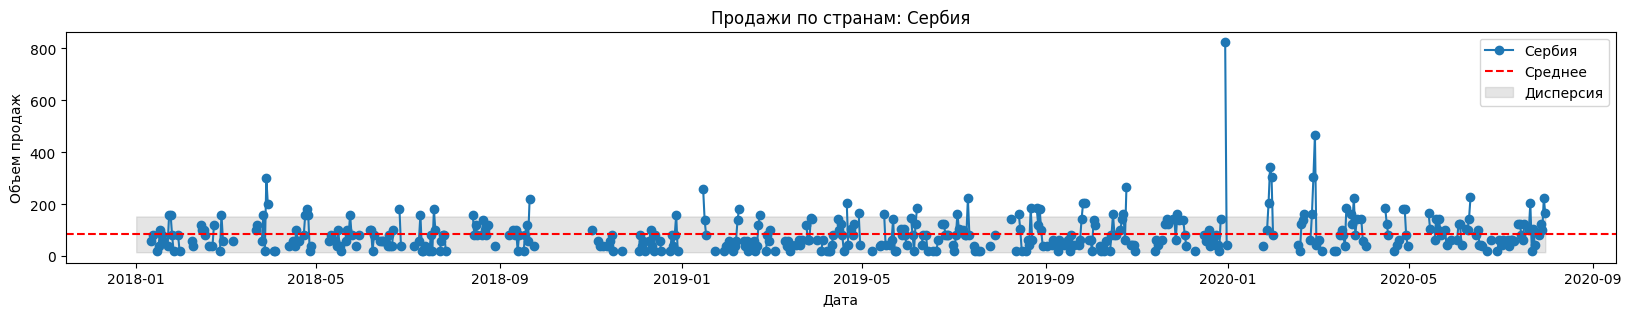

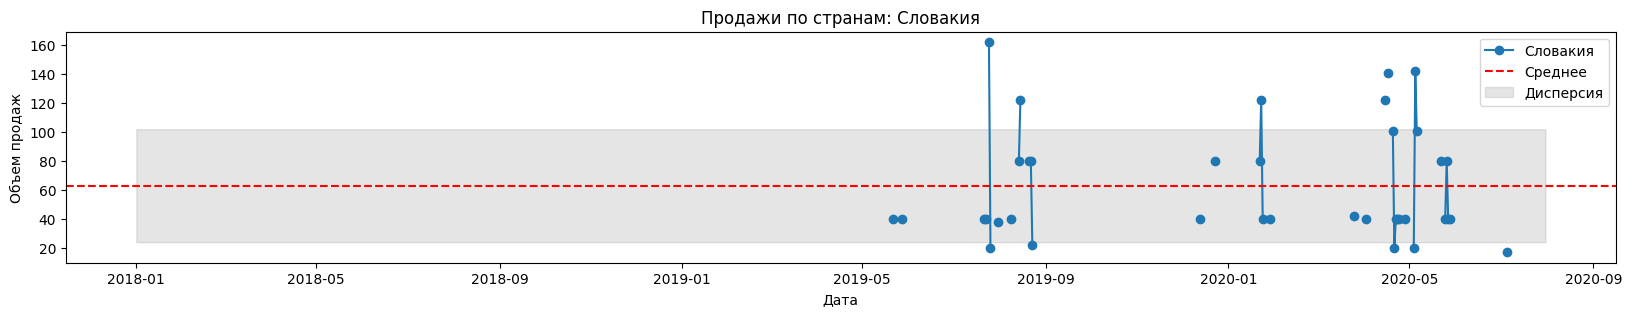

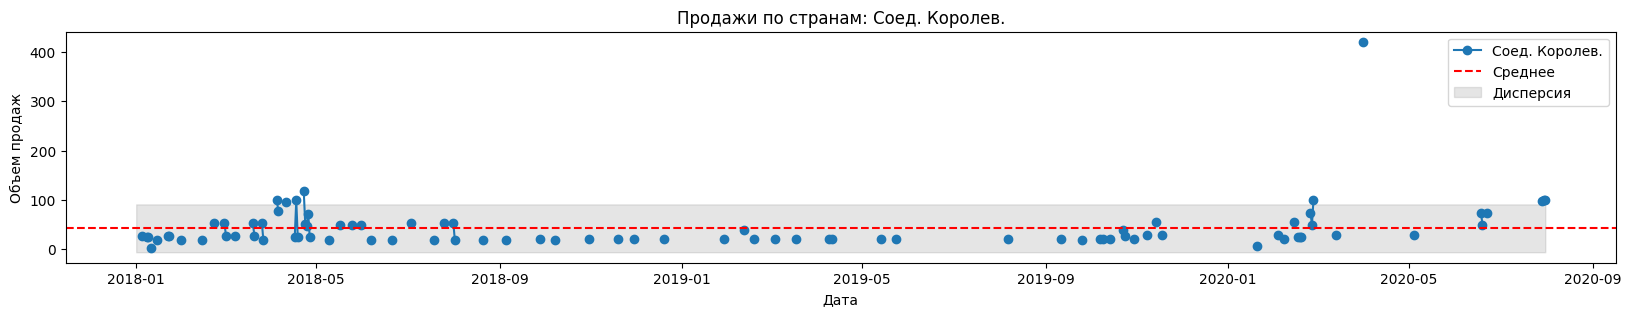

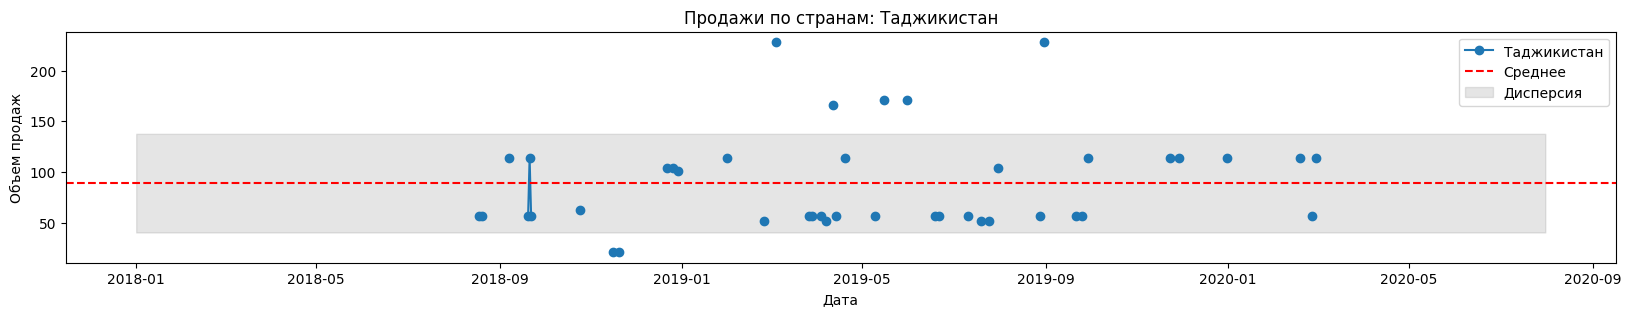

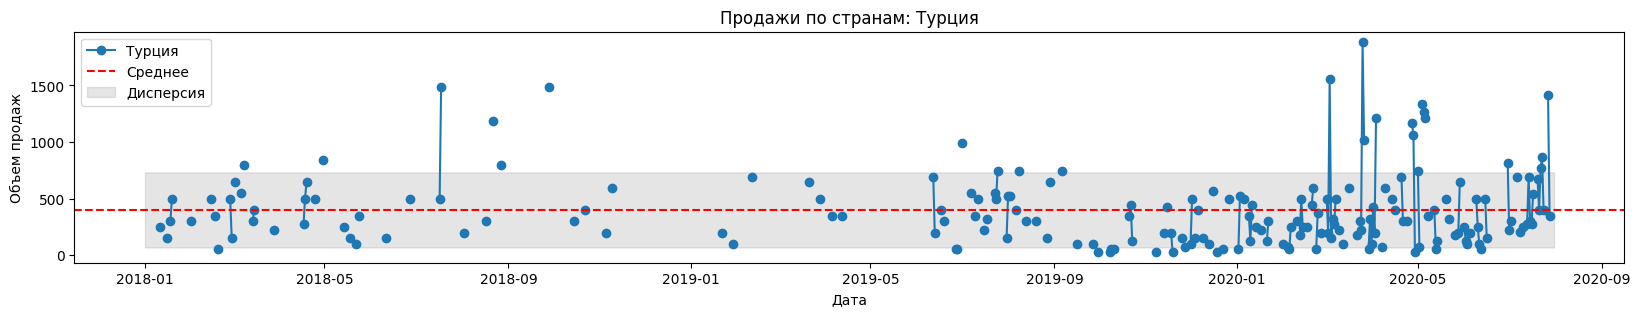

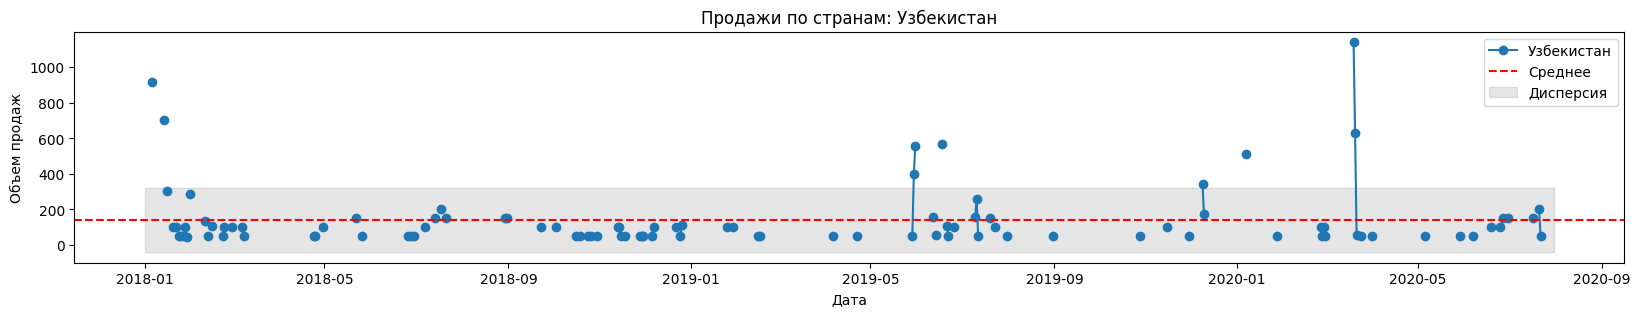

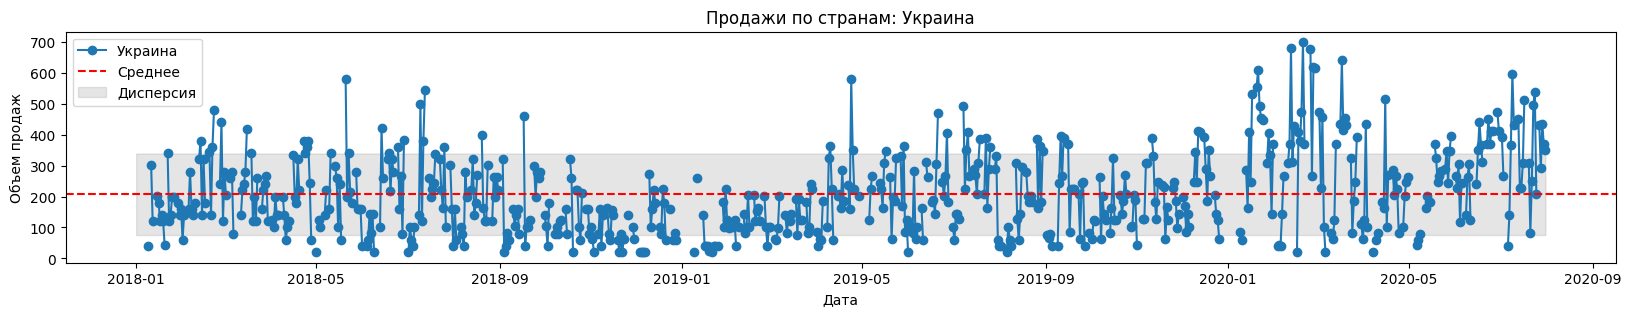

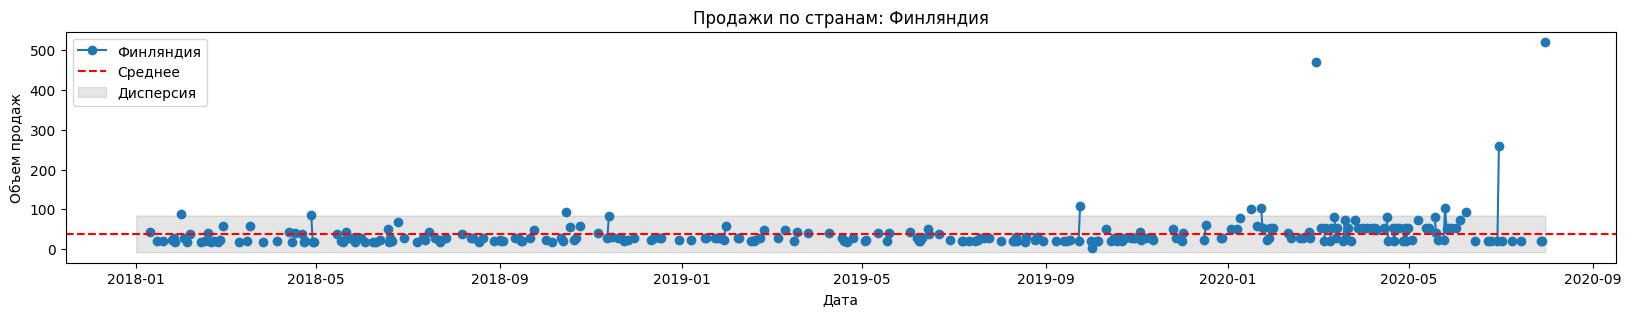

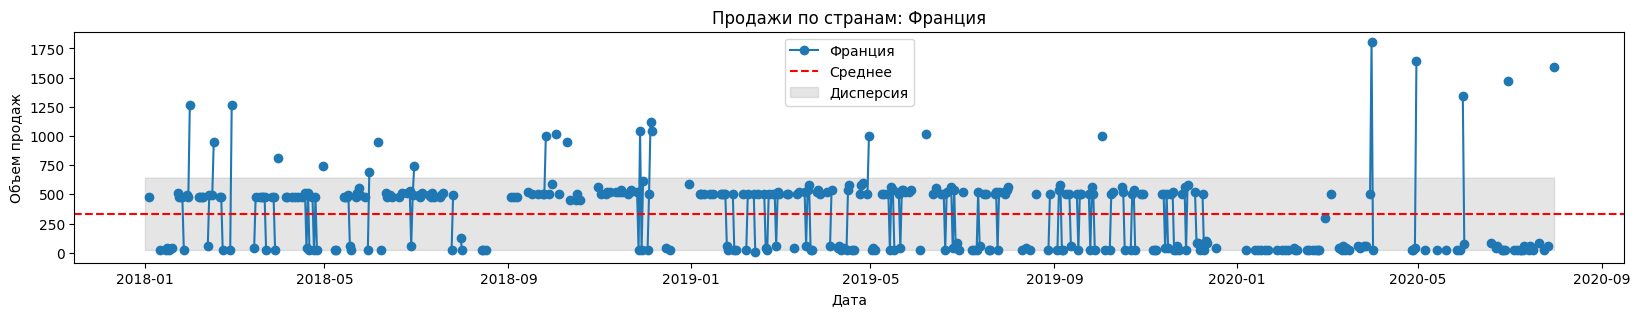

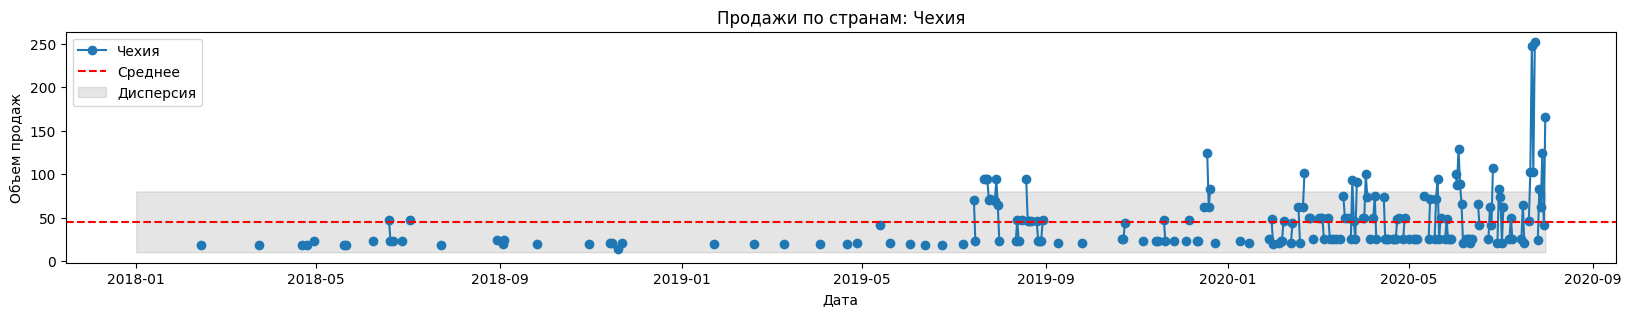

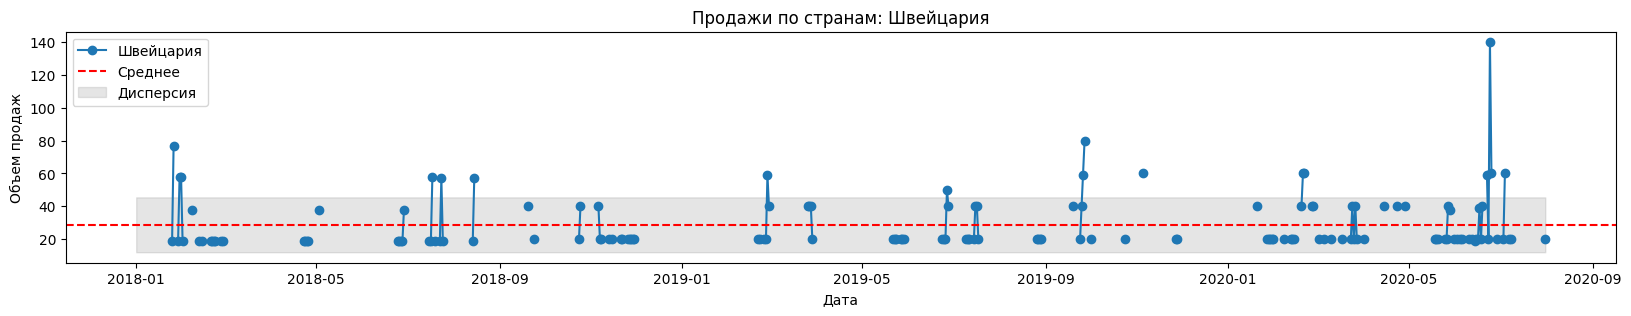

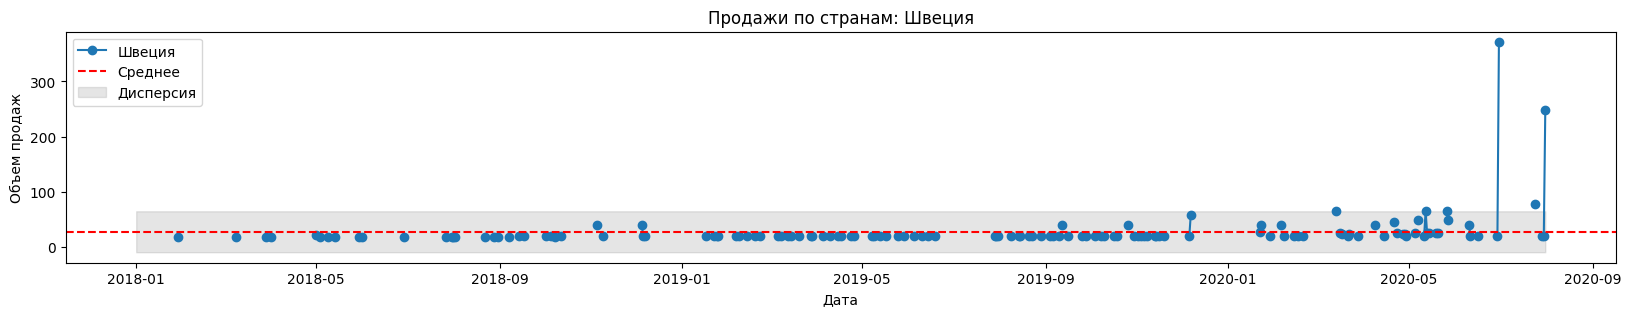

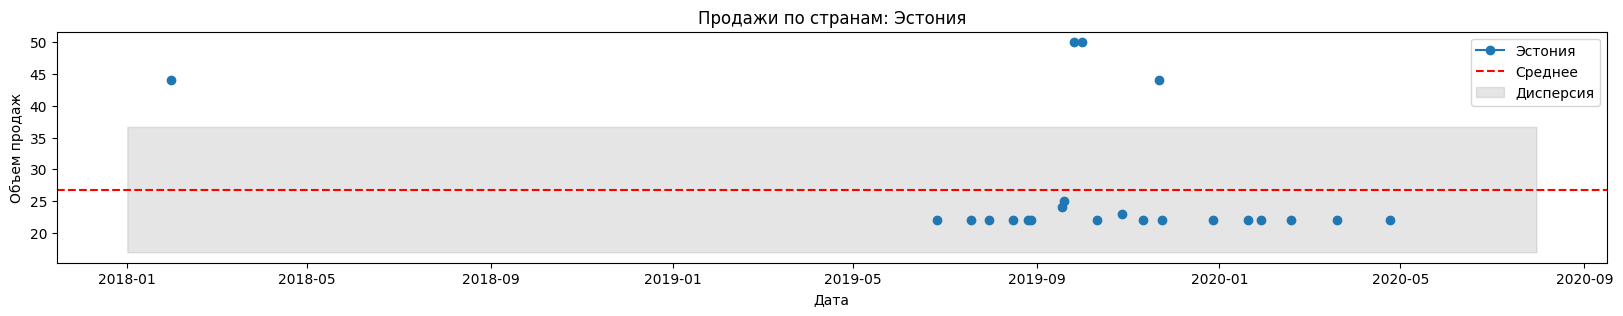

In [ ]:
grouped_data_2 = data.groupby(["date", "country"])["volume"].sum().reset_index()

# Преобразуем данные с помощью pivot
pivoted_data_2 = grouped_data_2.pivot(index="date", columns="country", values="volume")

for col in pivoted_data_2.columns:
    plt.figure(figsize=(20, 3))
    plt.plot(pivoted_data_2.index, pivoted_data_2[col], marker='o', label=col)
    plt.axhline(pivoted_data_2[col].mean(), color='r', linestyle='--', label='Среднее')
    plt.fill_between(pivoted_data_2.index, pivoted_data_2[col].mean() - pivoted_data_2[col].std(),
                     pivoted_data_2[col].mean() + pivoted_data_2[col].std(), color='gray', alpha=0.2, label='Дисперсия')
    plt.xlabel("Дата")
    plt.ylabel("Объем продаж")
    plt.title(f"Продажи по странам: {col}")
    plt.legend()
    plt.show()

## Визуализация по странам демонстрирует, что в РФ самая высокая дисперсия, по остальным странам ряды не полные

In [ ]:
print(pivoted_data.columns)

Index(['МЭГ', 'ПП', 'ПЭНП', 'Полистирол', 'Термоэластопласты'], dtype='object', name='material_lvl3_name')


In [ ]:
# Разбиваем выборку на отдельные датафреймы по виду полимера
polymer_a_df = pivoted_data["МЭГ"]
polymer_b_df = pivoted_data["ПП"]
polymer_c_df = pivoted_data["Полистирол"]
polymer_e_df = pivoted_data["Термоэластопласты"]
polymer_f_df = pivoted_data["ПЭНП"]

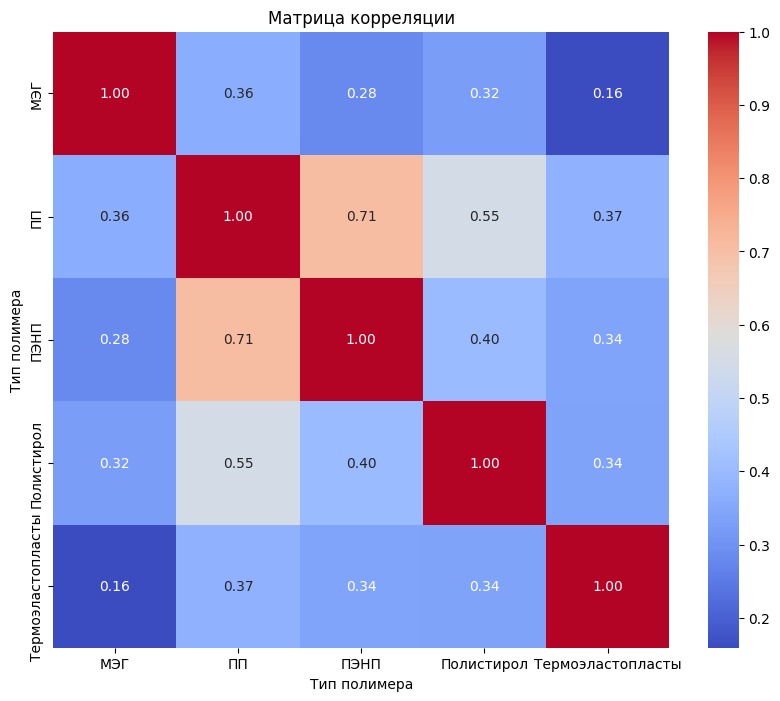

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = pivoted_data.corr()
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, ax=ax)

ax.set_title("Матрица корреляции")
ax.set_xlabel("Тип полимера")
ax.set_ylabel("Тип полимера")
plt.show()


## Высокую положительную корреляцию по продажам имеют ПЭНП и ПП - во многих сегментах они являются субститутами.

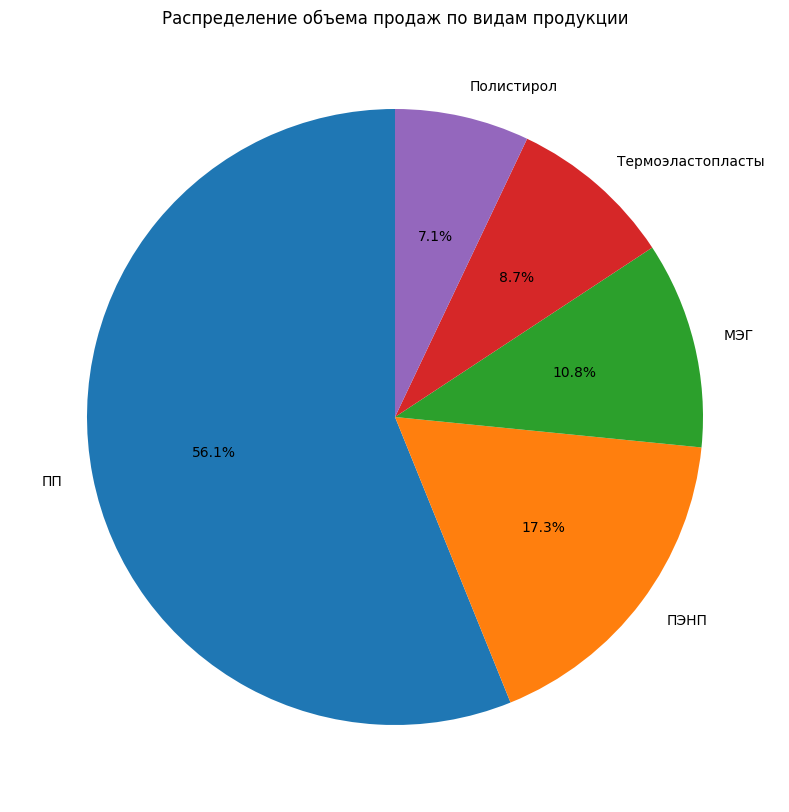

In [ ]:
product_volumes = data.groupby('material_lvl3_name')['volume'].sum().sort_values(ascending=False)
product_names = product_volumes.index.to_list()
product_values = product_volumes.values.tolist()

plt.figure(figsize=(15, 10))
plt.pie(product_values, labels=product_names, autopct="%1.1f%%", startangle=90)
plt.title("Распределение объема продаж по видам продукции")
plt.show()




---
## Порядка 73% всех продаж приходиться исключительно на два продукта - Полипропилен и ПЭНП. При этом у них положительная корреляция, разные средние (ПП - около 2000), у ПЭНП - порядка 500. Но дисперсия относительная не высокая и ряд не демонстрирует сильных выбросов.

---


## Раскладываем на компоненты

<Figure size 640x480 with 0 Axes>

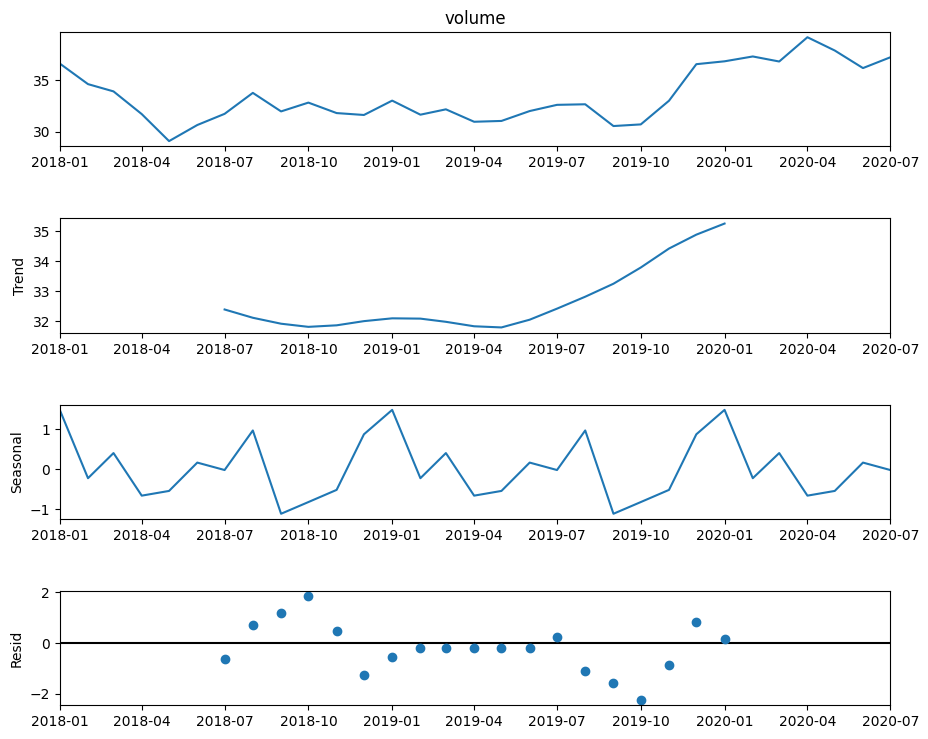

In [ ]:
train_plot = data.set_index('date')
y = train_plot['volume'].resample('MS').mean()

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(10, 8)

## Проверяем на стационарность посредство теска Дики-Фуллера

In [ ]:
## функция проверки
def test_stationarity(timeseries):
    # Определяем статистики
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Проводим тест Дики-Фуллера
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value

    orig = plt.plot(timeseries, color='blue',label='Original')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Определение стационарности на основе p-value и других метрик
    if dfoutput['p-value'] <= 0.05 and dfoutput['Test Statistic'] < dfoutput['Critical Value (1%)']:
        print("Ряд стационарен")
    else:
        print("Ряд нестационарен")

Results of Dickey-Fuller Test:


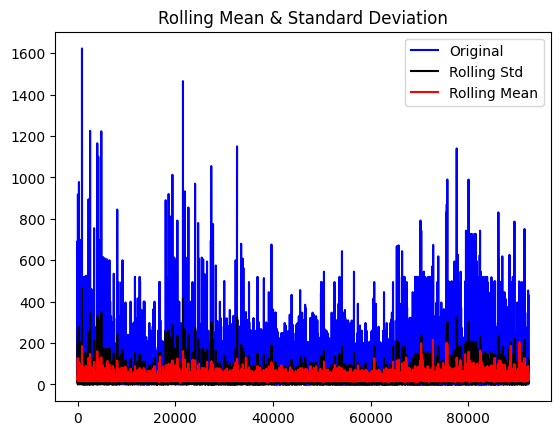

Ряд стационарен


In [ ]:
test_stationarity(data['volume'])

#### Формально тест Дикки-Фуллера показывает, что ряд стационарен, так как по значению p-value меньше 0.05. DF значение по модулю меньше критического значения. Однако, визуально видно, что ряд не стационарен. Это также потверждается тестом на стационарность методом скользязих средних и дисперсии. Для первичной итерации и построения baseline принимаем что ряд стационарен



---

# 2. Строим модели
## 2.1 Baseline - скользящая средняя из библиотеки ETNA

In [ ]:
df_mean = copy.deepcopy(train_plot)
df_mean.head()

material_code  company_code    country           region  \
date                                                                  
2018-01-01            134             0      Литва            Литва   
2018-01-02            197             0      Китай            Китай   
2018-01-02            794          2162  Казахстан  Атырауская обл.   
2018-01-02            134             0      Литва            Литва   
2018-01-02            133             0      Китай            Китай   

            manager_code      month material_lvl1_name material_lvl2_name  \
date                                                                        
2018-01-01         12261 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         16350 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         10942 2018-01-01   Базовые полимеры                 ПП   
2018-01-02         12261 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         17745 2018-01-01   Базовые полимеры                 ПЭ   

           material_lvl3_name contract_type  volume  
date                                                 
2018-01-01               ПЭНП          Спот    43.0  
2018-01-02               ПЭНП          Спот    95.0  
2018-01-02                 ПП      Контракт    57.0  
2018-01-02               ПЭНП          Спот    21.0  
2018-01-02               ПЭНП          Спот   150.0

In [ ]:
key_cols = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']
df_mean.drop(key_cols, axis=1, inplace=True)

In [ ]:
## сгрупируем по неделям
df_resampled_mean = df_mean.resample(rule='w').mean()
df_resampled_mean

volume
date                 
2018-01-07  55.746988
2018-01-14  37.730659
2018-01-21  39.874773
2018-01-28  32.554711
2018-02-04  33.225743
...               ...
2020-07-05  39.963158
2020-07-12  33.828283
2020-07-19  39.692029
2020-07-26  34.614118
2020-08-02  38.220748

[135 rows x 1 columns]

In [ ]:
df_resampled_mean = df_resampled_mean.reset_index()
print(df_resampled_mean.columns)

Index(['date', 'volume'], dtype='object')


ETNA имеет строгий формат данных:

tagret
timestamp
segment - потому что этна всегда готова работать с несколькими временными рядами, сегмент колонки также обязателен

In [ ]:
df_resampled_mean["timestamp"] = pd.to_datetime(df_resampled_mean["date"])
df_resampled_mean["target"] = df_resampled_mean["volume"]
df_resampled_mean.drop(columns=["date", "volume"], inplace=True)
df_resampled_mean["segment"] = "main"
df_resampled_mean.head()

timestamp     target segment
0 2018-01-07  55.746988    main
1 2018-01-14  37.730659    main
2 2018-01-21  39.874773    main
3 2018-01-28  32.554711    main
4 2018-02-04  33.225743    main

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


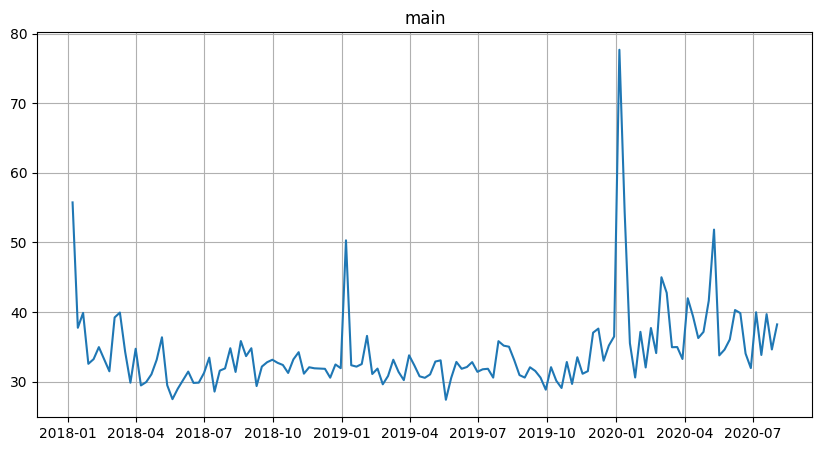

In [ ]:
df_etna = TSDataset.to_dataset(df_resampled_mean)
df_etna.head()

ts = TSDataset(df_etna, freq="W")
ts.plot()

In [ ]:
train_ts, test_ts = ts.train_test_split(
    train_start="2018-01-07",
    train_end="2020-04-01",
    test_start="2020-04-02",
    test_end="2020-08-02",
)
HORIZON = 18

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
model = SeasonalMovingAverageModel(window=5, seasonality=12)

In [ ]:
model.fit(train_ts)

SeasonalMovingAverageModel(window = 5, seasonality = 12, )

In [ ]:
future_ts = train_ts.make_future(future_steps=HORIZON,
tail_steps=model.context_size)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


In [ ]:
forecast_ts = model.forecast(future_ts,
prediction_size=HORIZON)


In [ ]:
print("test_ts.index:", test_ts.index)
print("forecast_ts.index:", forecast_ts.index)

test_ts.index: DatetimeIndex(['2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07', '2020-06-14', '2020-06-21',
               '2020-06-28', '2020-07-05', '2020-07-12', '2020-07-19',
               '2020-07-26', '2020-08-02'],
              dtype='datetime64[ns]', name='timestamp', freq='W-SUN')
forecast_ts.index: DatetimeIndex(['2020-04-05', '2020-04-12', '2020-04-19', '2020-04-26',
               '2020-05-03', '2020-05-10', '2020-05-17', '2020-05-24',
               '2020-05-31', '2020-06-07', '2020-06-14', '2020-06-21',
               '2020-06-28', '2020-07-05', '2020-07-12', '2020-07-19',
               '2020-07-26', '2020-08-02'],
              dtype='datetime64[ns]', name='timestamp', freq='W-SUN')


In [ ]:
mae = MAE()
mse = MSE()
mape = MAPE()

print("MAE:", mae(y_true=test_ts, y_pred=forecast_ts))
print("RMSE:", mse(y_true=test_ts, y_pred=forecast_ts))
print("MAPE:", mape(y_true=test_ts, y_pred=forecast_ts))

MAE: {'main': 5.812123277896019}
RMSE: {'main': 49.259497904413024}
MAPE: {'main': 14.597754072268943}


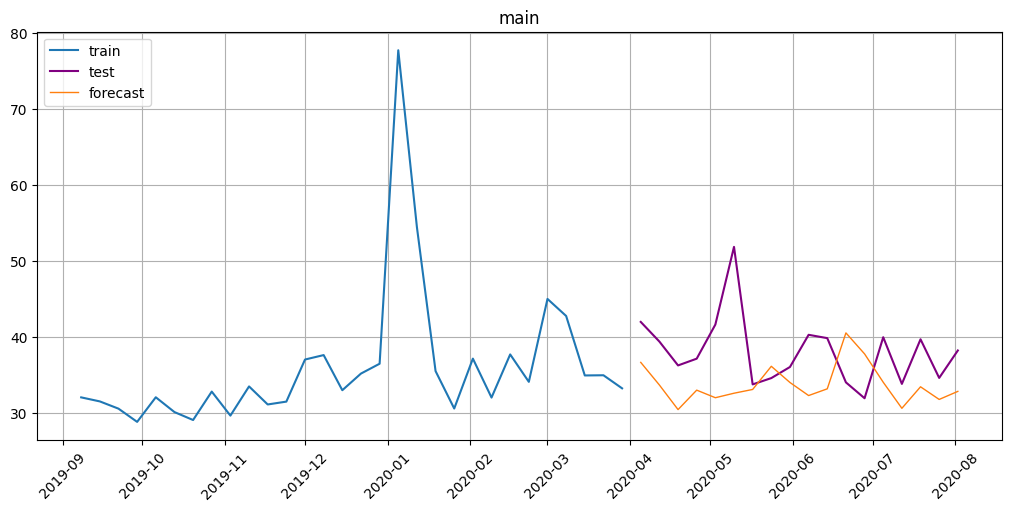

In [ ]:
plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=30)

### Базовая модель показала не совсем хорошие результаты

## 2.2 Работа с аномалиями. Будем использовать функции: get_anomalies_median(), get_anomalies_density() и get_anomalies_hist()
2.2.1 С помощью функции get_anomalies_median()
Согласно этому способу выбросы – это
все точки, отклоняющиеся от медианы более чем на alpha * std. Поясним некоторые
параметры:
- alpha – это порог (по умолчанию 3);
- std – выборочная дисперсия в окне размером window_size;
- window_size – размер окна или количество наблюдений (по умолчанию 10).

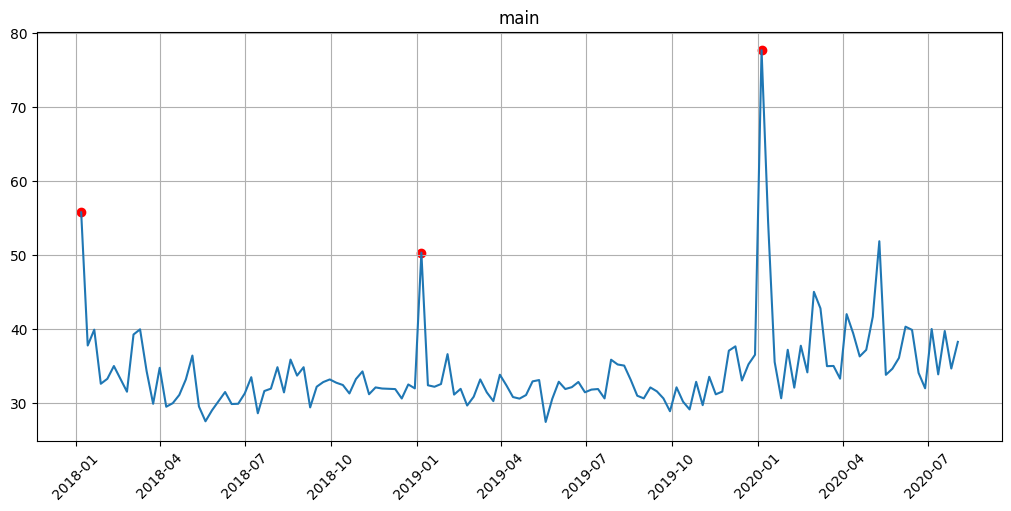

In [ ]:
anomaly_dict = get_anomalies_median(ts, window_size=100)
plot_anomalies(ts, anomaly_dict)

2.2.2 C помощью функции get_anomalies_density() проанализируем выбросы
на основе плотности. Согласно этому способу для каждой точки (элемента)
ряда мы строим все окна размера window_size, содержащие эту точку,
и если какое-либо из окон содержит по крайней мере n_neighbors, которые находятся
ближе, чем distance_coef * std(series), до интересующей точки в соответствии с distance_func, то интересущая нас точка не является выбросом.
Поясним некоторые параметры:
- window_size – размер окна (по умолчанию 15);
- n_neighbors – минимальное количество соседей точки, необходимое для
того, чтобы точка не была объявлена выбросом (по умолчанию 3);
- distance_coef – множитель для стандартного отклонения, который формирует
пороговое значение расстояния, при котором мы считаем точки
близко расположенными друг к другу (по умолчанию 3);
- distance_func – функция расстояния, которой по умолчанию является
абсолютная разница между двумя значениями.

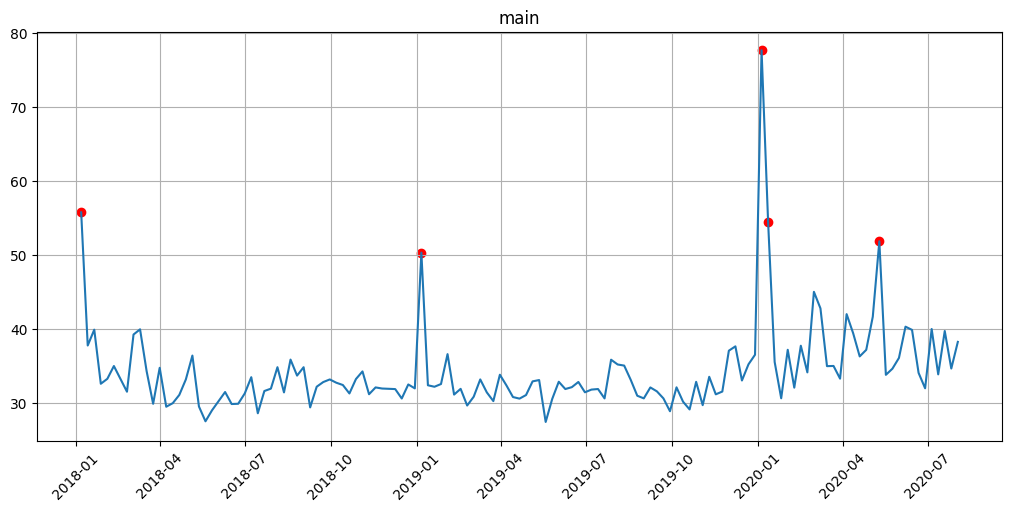

In [ ]:
anomaly_dict = get_anomalies_density(
ts,
window_size=18,
distance_coef=1,
n_neighbors=4)
plot_anomalies(ts, anomaly_dict)

2.2.3 с помощью функции get_anomalies_hist() проанализируем выбросы
на основе гистограммирования. Согласно этому способу, выбросы – это все
точки, удаление которых приводит к гистограмме с меньшей ошибкой аппроксимации,
даже если количество бинов (bins_number) меньше, чем количество
выбросов.

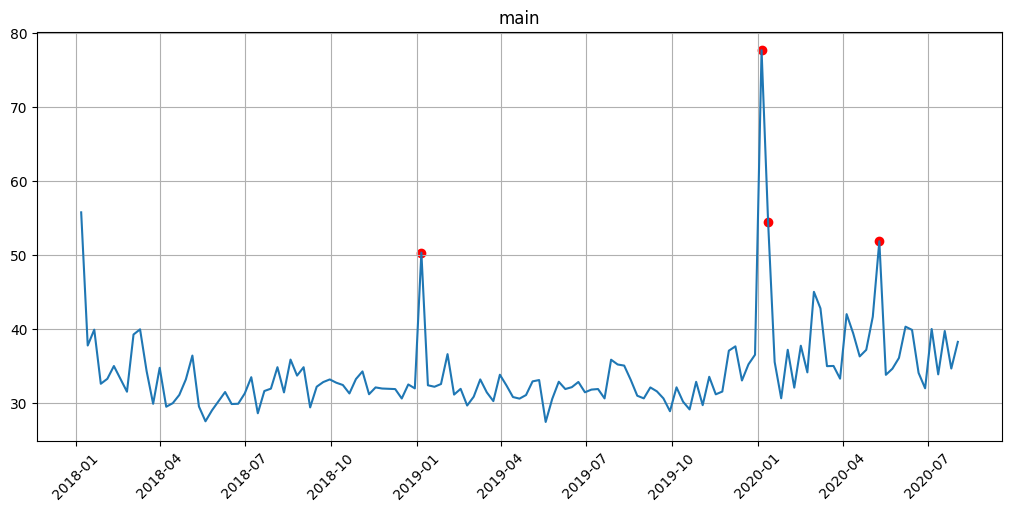

In [ ]:
anomaly_dict = get_anomalies_hist(ts, bins_number=10)
plot_anomalies(ts, anomaly_dict)

В библиотеке ETNA процесс обработки выбросов состоит из двух этапов:
1. Заменяем выбросы, обнаруженные с помощью определенного метода,
на значения NaN, используя экземпляр соответствующего класса
OutliersTransform.
2. Импутируем значения NaN с помощью класса TimeSeriesImputerTransform.
Давайте импутируем выбросы, обнаруженные с помощью медианного метода,
используя стратегию running_mean.

In [ ]:
best_params = {'window_size':60,
'alpha':2}

In [ ]:
ts_clean = copy.deepcopy(ts)

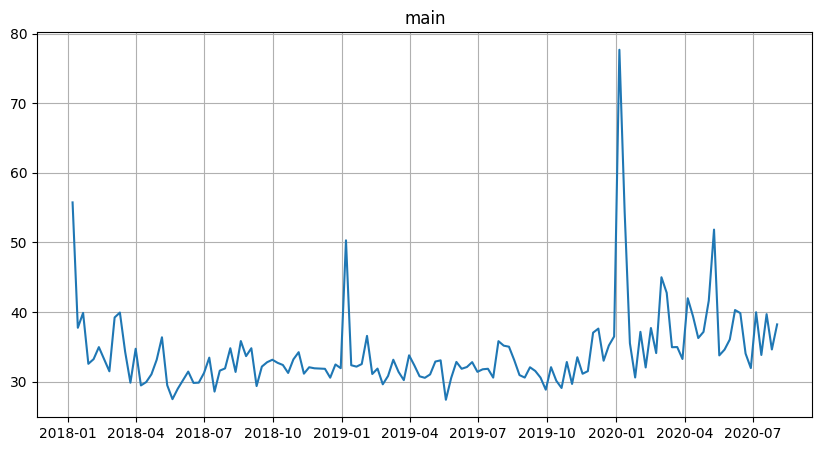

In [ ]:
ts_clean.plot()

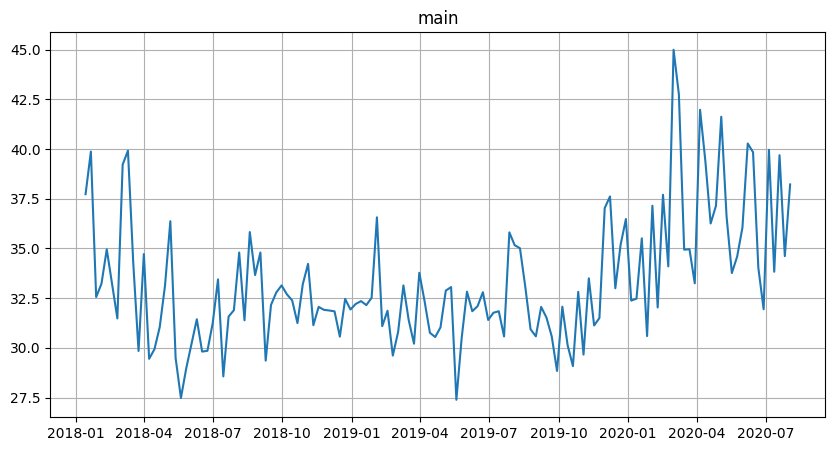

In [ ]:
# заменяем выбросы на NaN
outliers_remover = MedianOutliersTransform(
in_column='target',
**best_params)
# импутируем значения NaNs с помощью скользящего среднего
outliers_imputer = TimeSeriesImputerTransform(
in_column='target', strategy='running_mean', window=18)
ts_clean.fit_transform([outliers_remover, outliers_imputer])
ts_clean.plot()

In [ ]:
# пишем функцию, вычисляющую метрики качества прогнозов
def get_metrics(forecast, test):

    metrics = {'MAE':MAE(), 'MSE':MSE(), 'MAPE':MAPE()}
    results = dict()
    for name, metric in metrics.items():
      results[name] = metric(y_true = test, y_pred = forecast)
    return results


In [ ]:
from etna.pipeline import Pipeline

In [ ]:
# пишем функцию, которая строит модель скользящего
# среднего и оценивает качество прогнозов
def test_transforms(data, pipeline):
    """
    Строит модель и оценивает качество прогнозов
    """
    train, test = data.train_test_split(
        train_start="2018-01-07",
        train_end="2020-04-01",
        test_start="2020-04-02",
        test_end="2020-08-02",
    )
    model = pipeline
    model.fit(train)
    forecast = model.forecast()
    metrics = get_metrics(forecast, test)
    plot_forecast(forecast, test, train, n_train_samples=100)
    return metrics

In [ ]:
pipeline_sm = Pipeline(model=SeasonalMovingAverageModel(window=5, seasonality=12),
    horizon=18)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


{'MAE': {'main': 5.812123277896019},
 'MSE': {'main': 49.259497904413024},
 'MAPE': {'main': 14.597754072268943}}

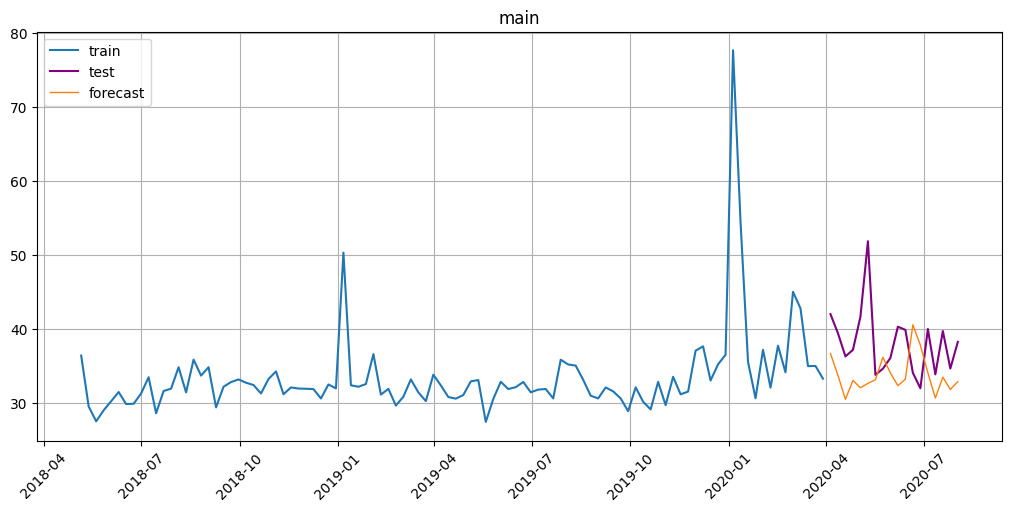

In [ ]:
test_transforms(ts, pipeline_sm)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


{'MAE': {'main': 4.966831156868801},
 'MSE': {'main': 29.600875399236315},
 'MAPE': {'main': 13.146162803491574}}

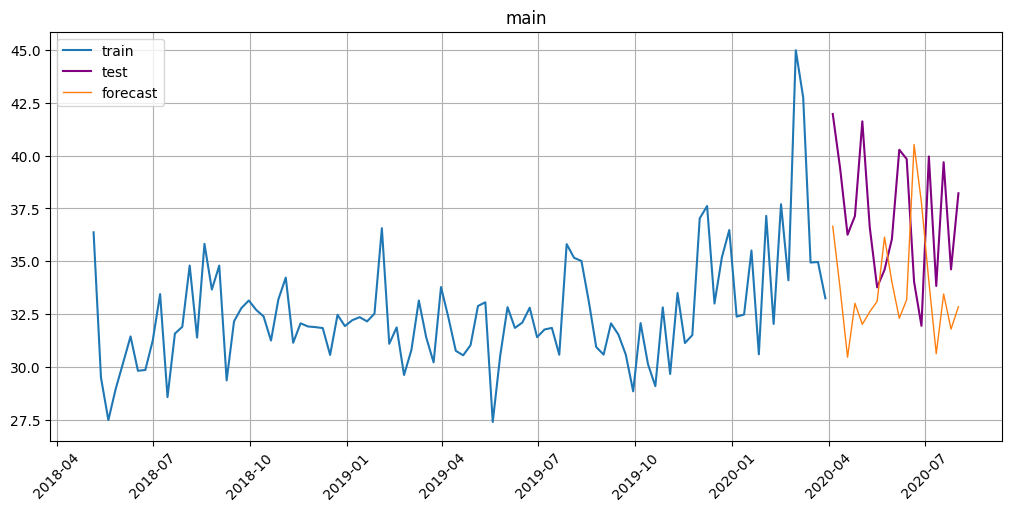

In [ ]:
test_transforms(ts_clean, pipeline_sm)

 Как и ожидалось, замена скользящим средним значительно снизило ошибку и улучшило прогноз. Но на графике видно, что предсказания очень далеки от истины

In [ ]:
def cross_validate_time_series(ts_clean: TSDataset, splits=[0.7, 0.8, 0.9]):
    """
    Выполняет временную кросс-валидацию и возвращает метрики для разных разбиений.

    Args:
        ts_clean (TSDataset): Очищенные временные ряды из etna.datasets.tsdataset.TSDataset.
        splits (list of float): Список разбиений на обучающую и тестовую выборки (например, [0.7, 0.8, 0.9]).

    Returns:
        pd.DataFrame: Таблица с разбиениями и метриками оценки.
    """
    results = []
    for split in splits:
        train_end_index = int(ts_clean.shape[0] * split)
        train, test = ts_clean[:train_end_index], ts_clean[train_end_index:]

        # Создайте и обучите свою модель (замените на вашу фактическую модель)
        model = Pipeline(steps=[("model", SeasonalMovingAverageModel(window=5, seasonality=12))])
        model.fit(train)
        forecast = model.predict(horizon=18)

        # Рассчитайте метрики (замените на фактический расчет метрик)
        metrics = get_metrics(forecast, test)

        # Добавьте результаты
        results.append({
            "Split": f"{split:.0%}",
            "MAE": metrics["MAE"],
            "MSE": metrics["MSE"],
            "MAPE": metrics["MAPE"]
        })

    # Создайте DataFrame
    result_df = pd.DataFrame(results)
    return result_df


в библиотеке ENTA нет функции len() или shape(), в документации тоже нет информацию по адекватному сплитированию

In [ ]:
## Видимо для скользящего среднего в ETNA нет перекрестная проверка расширяющим окном
pipeline_sma = Pipeline(model=SeasonalMovingAverageModel(window=5, seasonality=12),
    horizon=18)
metrics, forecast, info = pipeline_sma.backtest(ts=ts, metrics=[mape], n_folds=1)

print(metrics)

## 2.3 Строим модели Prophet и Catboost из коробки ENTA

Prophet

In [ ]:
# не будем делать никаких преобразований
transforms = []
pipeline_prophet = Pipeline(model=ProphetModel(),transforms=transforms,
    horizon=18)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpejba6sm2/56gdyr_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpejba6sm2/9xenr5tz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52322', 'data', 'file=/tmp/tmpejba6sm2/56gdyr_a.json', 'init=/tmp/tmpejba6sm2/9xenr5tz.json', 'output', 'file=/tmp

{'MAE': {'main': 4.049216660848929},
 'MSE': {'main': 24.025313644488467},
 'MAPE': {'main': 10.423243969092765}}

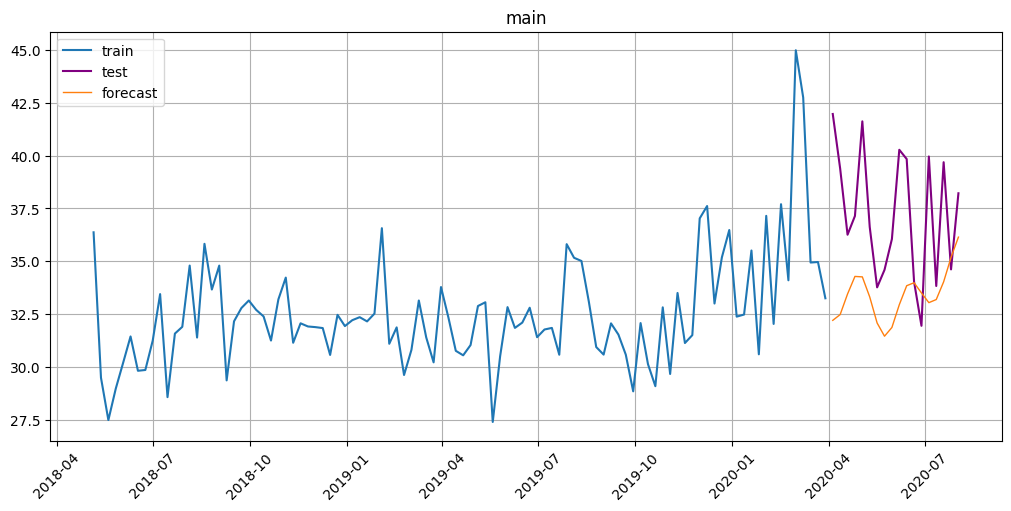

In [ ]:
test_transforms(ts_clean, pipeline_prophet)

Catboost

In [ ]:
from catboost import CatBoostRegressor, Pool
from etna.models import CatBoostMultiSegmentModel

Для работы Catboost из коробки обязательно добавление скользящее среднее и лагов

In [ ]:
lags = LagTransform(in_column='target',
lags=list(range(8, 24, 1)),
out_column='lag')

In [ ]:
mean8 = MeanTransform(in_column='target',
window=8,
out_column='mean8')

In [ ]:
pipeline_catboost = Pipeline(model=CatBoostMultiSegmentModel(loss_function='MAE',
n_estimators=600,
learning_rate=0.05,
depth=9,
random_seed=42),transforms=[lags, mean8],
    horizon=18)

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:282: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(


{'MAE': {'main': 4.884164384545051},
 'MSE': {'main': 31.57220478941553},
 'MAPE': {'main': 12.620407045414533}}

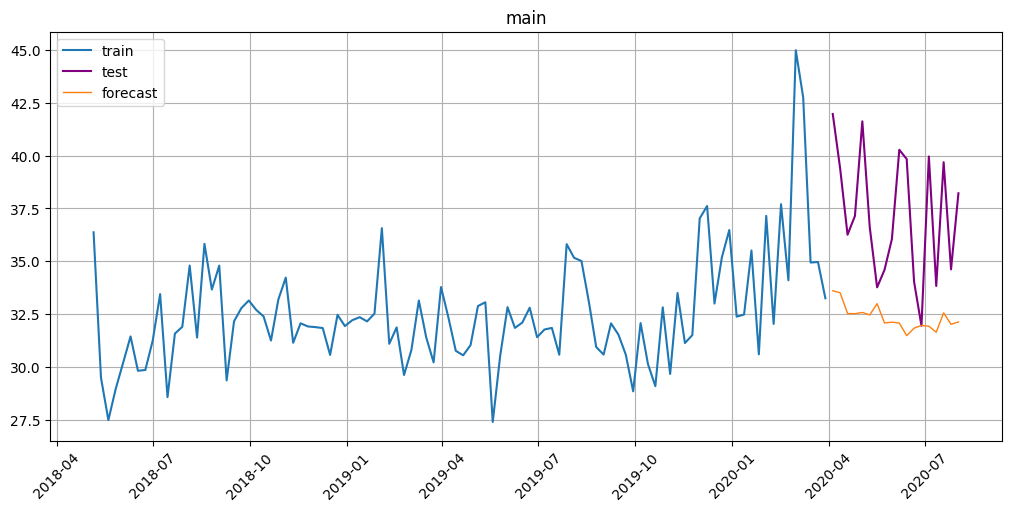

In [ ]:
test_transforms(ts_clean, pipeline_catboost)


---

На основе базовых моделей, можно сделать вывод, что лучше всего с прогнозом
справляется Prophet
- Prophet: MAPE ~ 10
- SM ~ 14
- Catboost ~ 12


---


Для Catboost и Prophet добавим кросс-валидацию
Запустить перекрестную проверку можно с помощью метода .backtest() класса
Pipeline. Передаем в метод набор данных и указываем следующие параметры:
- metrics – список метрик;
- n_folds – количество тестовых выборок перекрестной проверки (по
умолчанию 5);
- mode – режим перекрестной проверки (по умолчанию 'expand', можно
задать 'expand'– перекрестную проверку расширяющимся окном или
'constant' – перекрестную проверку скользящим окном);
- aggregate_metrics – агрегирование метрик по тестовым выборкам перекрестной
проверки (по умолчанию False);
- n_jobs – количество ядер процессора для распараллеливания (по умолчанию
1).

Метод .backtest() возвращает три датафрейма – датафрейм с метриками
по каждой тестовой выборке перекрестной проверки, датафрейм с прогнозами,
датафрейм с временными метками обучающей и тестовой выборок перекрестной
проверки.



In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline_prophet.backtest(
mode='expand', ts=ts_clean, metrics=[mape, mae, mse])
metrics_df

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/prophet/serialize.py:172: FutureWarning: The behavior of Timestamp.utcfromtimestamp is deprecated, in a future version will return a timezone-aware Timestamp with UTC timezone. To keep the old behavior, use Timestamp.utcfromtimestamp(ts).tz_localize(None). To get the future behavior, use Timestamp.fromtimestamp(ts, 'UTC')
  setattr(model, attribute, pd.Timestamp.utcfromtimestamp(model_dict[attribute]).tz_localize(None))
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonali

segment       MAPE       MAE        MSE  fold_number
0    main   2.471648  0.812202   1.896907            0
0    main   3.538437  1.086419   2.062812            1
0    main   4.889816  1.596768   4.148875            2
0    main  11.961479  4.541356  32.702686            3
0    main  10.423244  4.049217  24.025314            4

In [ ]:
# смотрим первые пять строк
# датафрейма с прогнозами
forecast_df.head()

segment           main           
feature    fold_number     target
timestamp                        
2018-11-18           0  31.898677
2018-11-25           0  31.887418
2018-12-02           0  31.876159
2018-12-09           0  31.864899
2018-12-16           0  31.853640

In [ ]:
# смотрим датафрейм с временными метками
# обучающей и тестовой выборок
fold_info_df

train_start_time train_end_time test_start_time test_end_time  fold_number
0       2018-01-07     2018-11-11      2018-11-18    2019-03-17            0
1       2018-01-07     2019-03-17      2019-03-24    2019-07-21            1
2       2018-01-07     2019-07-21      2019-07-28    2019-11-24            2
3       2018-01-07     2019-11-24      2019-12-01    2020-03-29            3
4       2018-01-07     2020-03-29      2020-04-05    2020-08-02            4

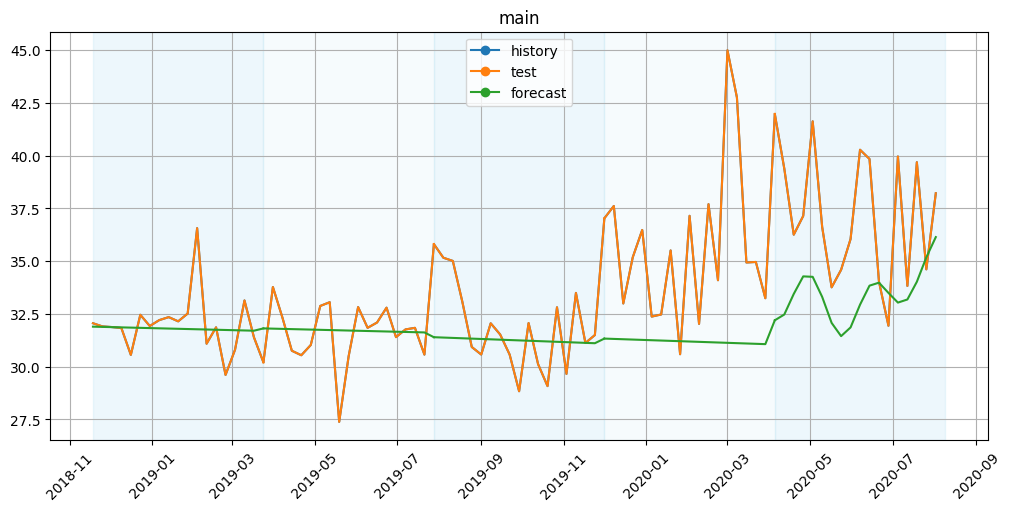

In [ ]:
# визуализируем результаты перекрестной проверки
plot_backtest(forecast_df, ts_clean)

Catboost

In [ ]:
metrics_df, forecast_df, fold_info_df = pipeline_catboost.backtest(
mode='expand', ts=ts_clean, metrics=[mape, mae, mse])
metrics_df

/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.8s
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W
  warnings.warn(
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    4.7s
/usr/local/lib/python3.10/dist-packages/etna/datasets/tsdataset.py:147: UserWarning: You probably set wrong freq. Discovered freq in you data is W-SUN, you set W


segment       MAPE       MAE        MSE  fold_number
0    main   2.878791  0.939354   1.916572            0
0    main   3.743449  1.145982   2.148169            1
0    main   4.829414  1.548611   3.527251            2
0    main  10.296579  3.944490  27.243545            3
0    main  12.620407  4.884164  31.572205            4

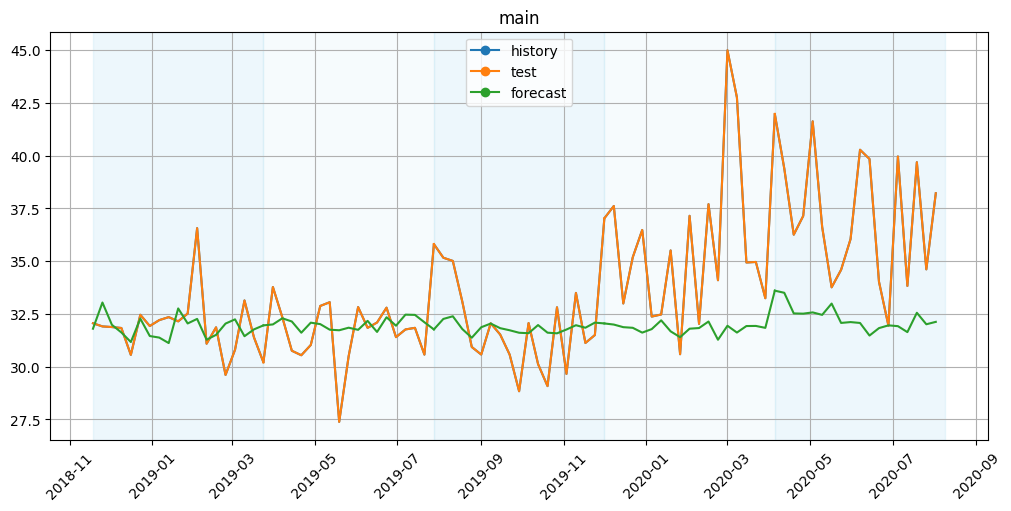

In [ ]:
# визуализируем результаты перекрестной проверки
plot_backtest(forecast_df, ts_clean)

## 3. Строим класичесскую модель Prophet

In [ ]:
df_pr = copy.deepcopy(train_plot)
df_pr.head()

material_code  company_code    country           region  \
date                                                                  
2018-01-01            134             0      Литва            Литва   
2018-01-02            197             0      Китай            Китай   
2018-01-02            794          2162  Казахстан  Атырауская обл.   
2018-01-02            134             0      Литва            Литва   
2018-01-02            133             0      Китай            Китай   

            manager_code      month material_lvl1_name material_lvl2_name  \
date                                                                        
2018-01-01         12261 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         16350 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         10942 2018-01-01   Базовые полимеры                 ПП   
2018-01-02         12261 2018-01-01   Базовые полимеры                 ПЭ   
2018-01-02         17745 2018-01-01   Базовые полимеры                 ПЭ   

           material_lvl3_name contract_type  volume  
date                                                 
2018-01-01               ПЭНП          Спот    43.0  
2018-01-02               ПЭНП          Спот    95.0  
2018-01-02                 ПП      Контракт    57.0  
2018-01-02               ПЭНП          Спот    21.0  
2018-01-02               ПЭНП          Спот   150.0

In [ ]:
key_cols = ["material_code", "company_code", "country", "region", "manager_code", "month", "contract_type", 'material_lvl1_name', 'material_lvl2_name', 'material_lvl3_name']

In [ ]:
df_pr.drop(key_cols, axis=1, inplace=True)
df_pr = df_pr.resample(rule='w').mean()
df_pr

volume
date                 
2018-01-07  55.746988
2018-01-14  37.730659
2018-01-21  39.874773
2018-01-28  32.554711
2018-02-04  33.225743
...               ...
2020-07-05  39.963158
2020-07-12  33.828283
2020-07-19  39.692029
2020-07-26  34.614118
2020-08-02  38.220748

[135 rows x 1 columns]

In [ ]:
df_pr = df_pr.reset_index()
print(df_pr.columns)

Index(['date', 'volume'], dtype='object')


In [ ]:
df_pr = df_pr.rename(columns={'date': 'ds', 'volume': 'y'})
df_pr.head()


ds          y
0 2018-01-07  55.746988
1 2018-01-14  37.730659
2 2018-01-21  39.874773
3 2018-01-28  32.554711
4 2018-02-04  33.225743

Подготовляем модель заменяя выбросы скользящим средним.

In [ ]:
df6 = df_pr.copy()

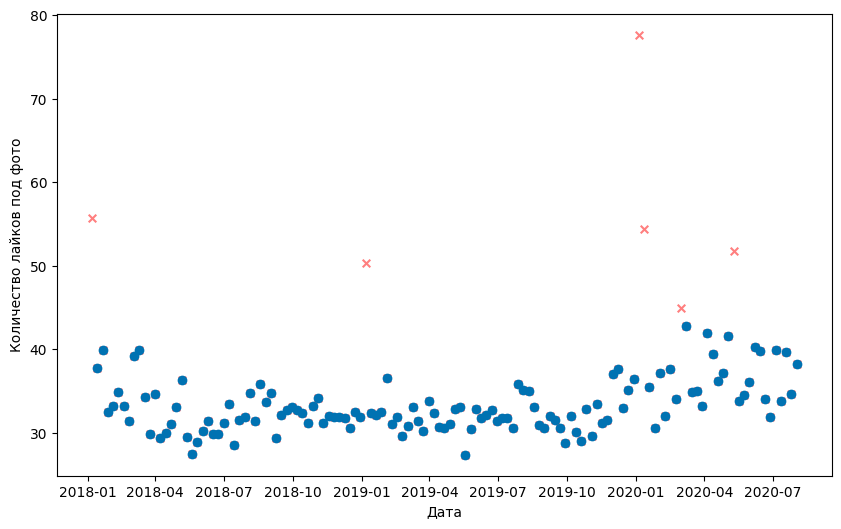

In [ ]:
df6['moving_average'] = df6.rolling(window=300,
min_periods=1,
center=True,
on='ds')['y'].mean()
df6['std_dev'] = df6.rolling(window=300,
min_periods=1,
center=True,
on='ds')['y'].std()
df6['lower'] = df6['moving_average'] - 1.65 * df6['std_dev']
df6['upper'] = df6['moving_average'] + 1.65 * df6['std_dev']
df6 = df6[(df6['y'] < df6['upper']) & (df6['y'] > df6['lower'])]
# визуализируем данные
plt.figure(figsize=(10, 6))
plt.scatter(x=df_pr['ds'], y=df_pr['y'], c='r',
alpha=.5, marker='x', s=30)
plt.scatter(x=df6['ds'], y=df6['y'], c='#0072B2')
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel('Дата')
plt.ylabel('Количество продаж')
plt.show()

<Axes: xlabel='ds'>

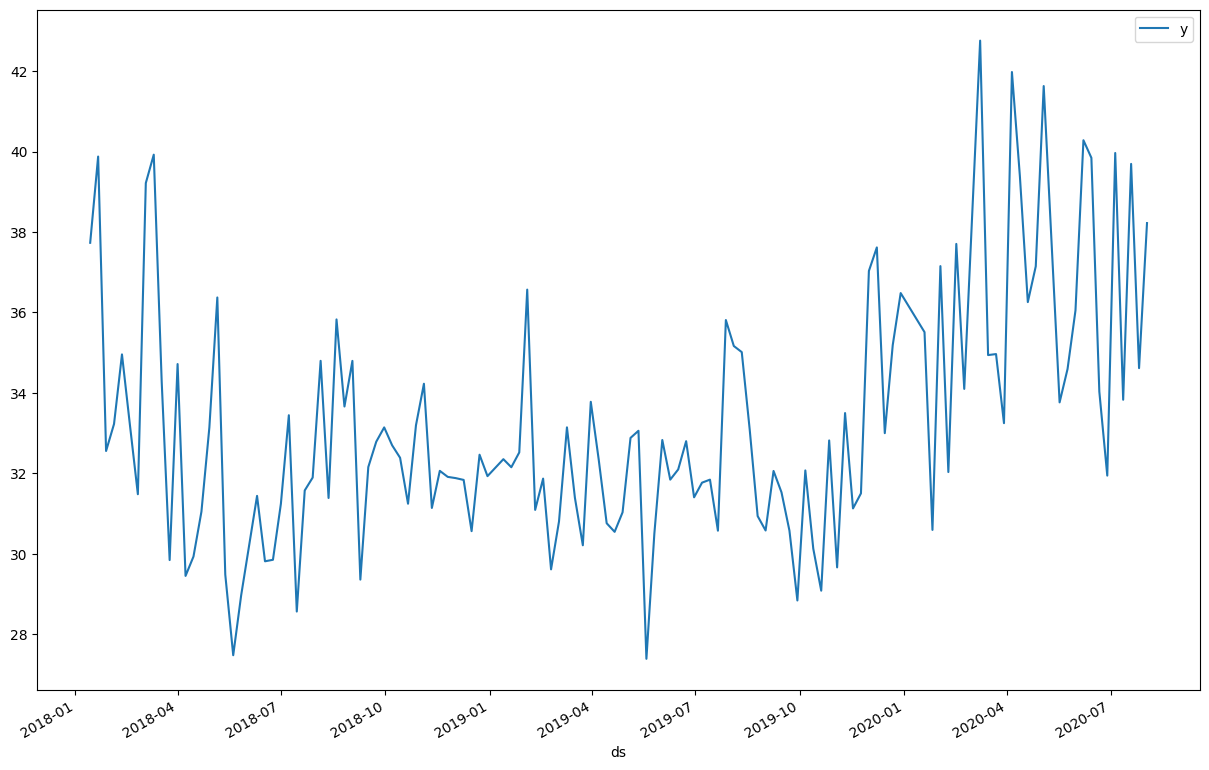

In [ ]:
df6.plot(x = "ds", y = "y", figsize = (15,10))

Удалили выбросы

In [ ]:
df6.drop(['moving_average', 'std_dev', 'lower', 'upper'], axis=1, inplace=True)
df6 = df6.reset_index(drop=True)
# переименуем столбцы
df6.columns = ['ds', 'y']

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmq17ub88/z1wddcg9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmq17ub88/471voz72.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38627', 'data', 'file=/tmp/tmpmq17ub88/z1wddcg9.json', 'init=/tmp/tmpmq17ub88/471voz72.json', 'output', 'file=/tmp/tmpmq17ub88/prophet_model0f5tjnc3/prophet_model-20240315124526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:45:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MAPE %: 7.593745136568436 MAE: 2.784347555942963 MSE: 2.784347555942963


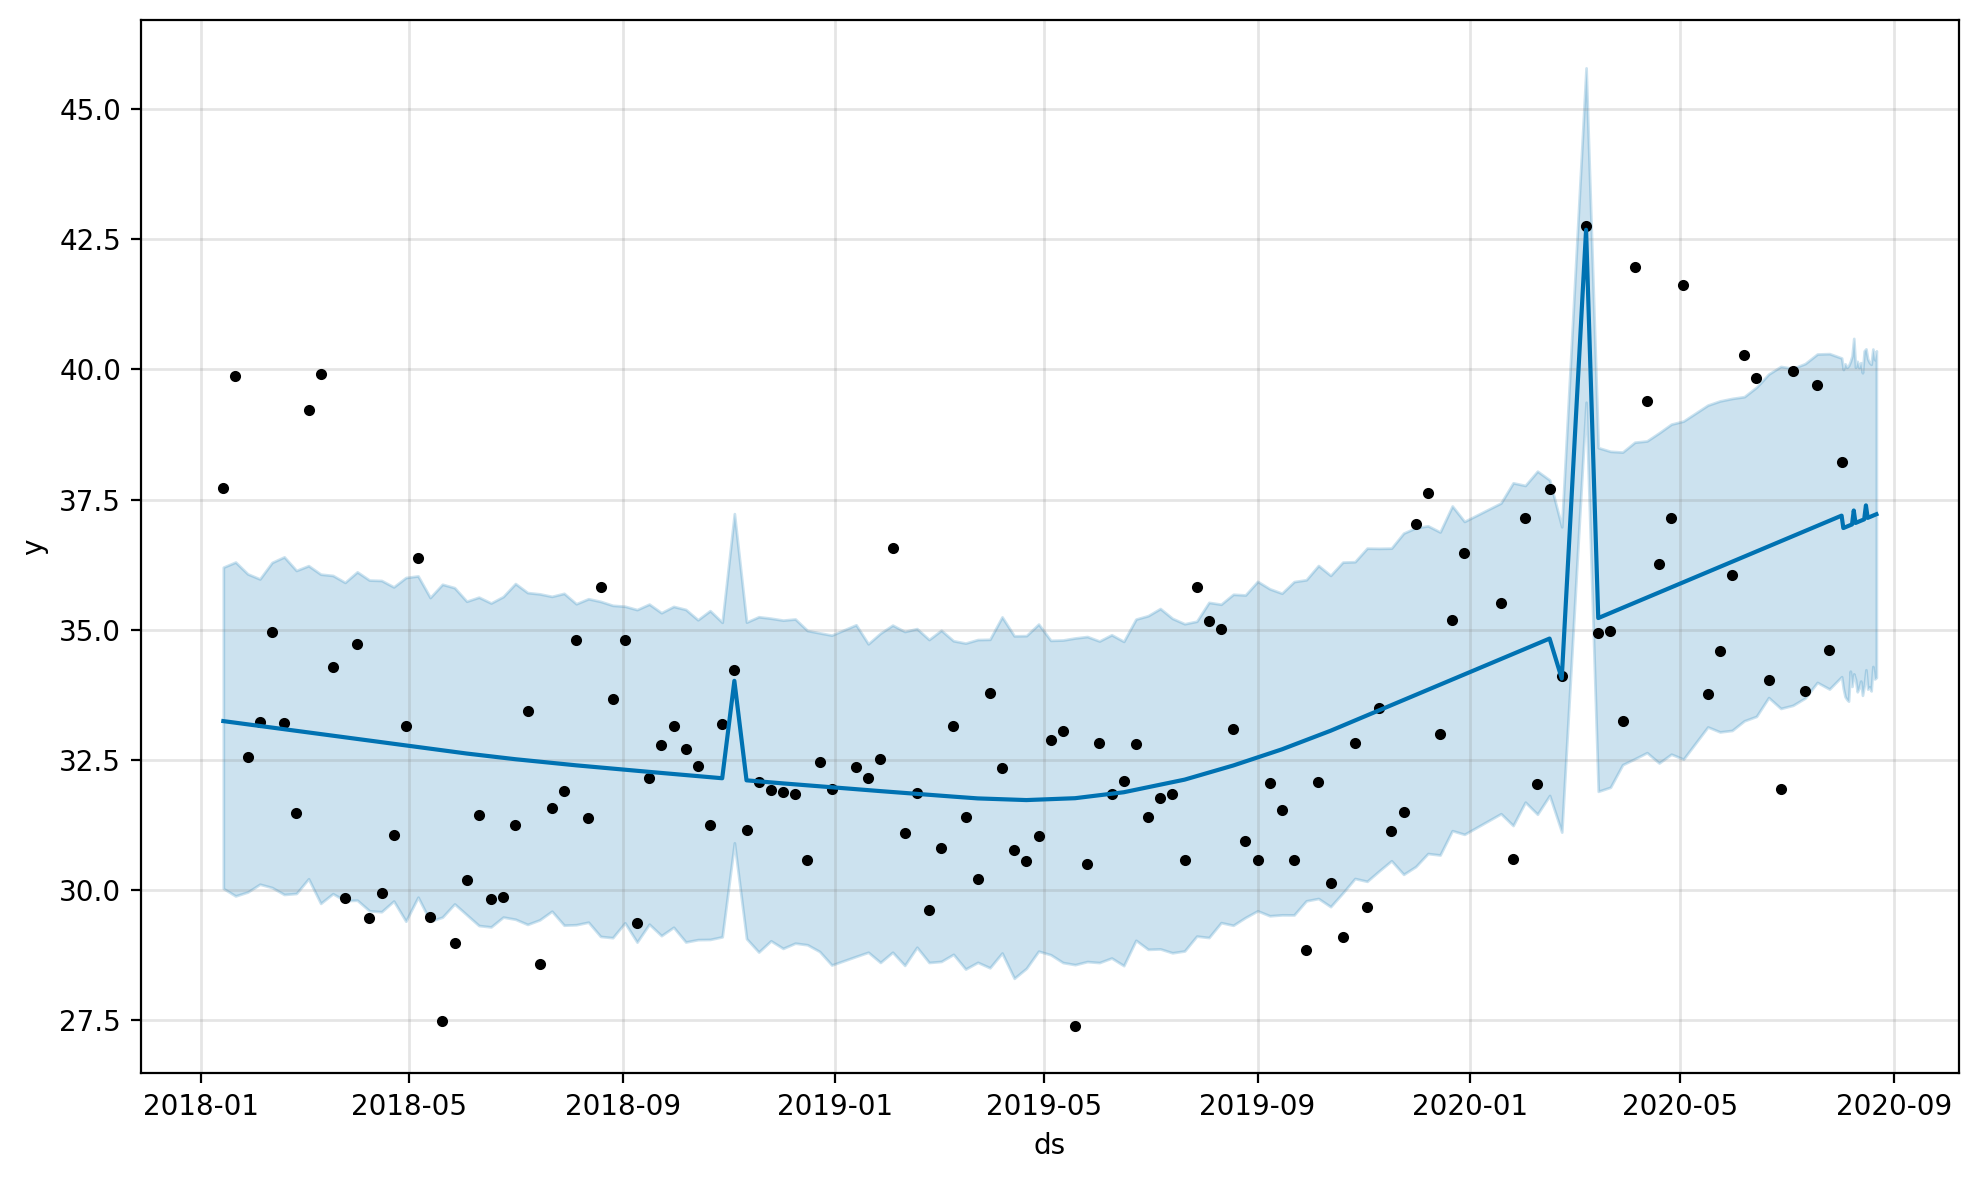

In [ ]:
# создаем модель
from prophet import Prophet
model = Prophet(weekly_seasonality=6, yearly_seasonality=False, seasonality_mode='multiplicative', seasonality_prior_scale=.01, holidays_prior_scale=5)
model.add_country_holidays(country_name='RU')
model.fit(df6)
# делаем предсказания
future = model.make_future_dataframe(periods=20)
forecast = model.predict(future)
# оцениваем качество
from sklearn.metrics import mean_absolute_percentage_error
y_true = df6['y'][-18:]
y_pred = forecast['yhat'][-18:]
print('MAPE %:', MAPE(y_true, y_pred)*100,
      'MAE:', MAE(y_true, y_pred),
      'MSE:', MAE(y_true, y_pred))
# строим график
model.plot(forecast, figsize=(10, 6))
plt.show()


## Как видим, prophet очень хорошо справляется данными. MAPE меньше чем у других моделей, это значит что предсказанные данные отличаются от фактических на 7%, при условии если мы предсказываем на 20 недель

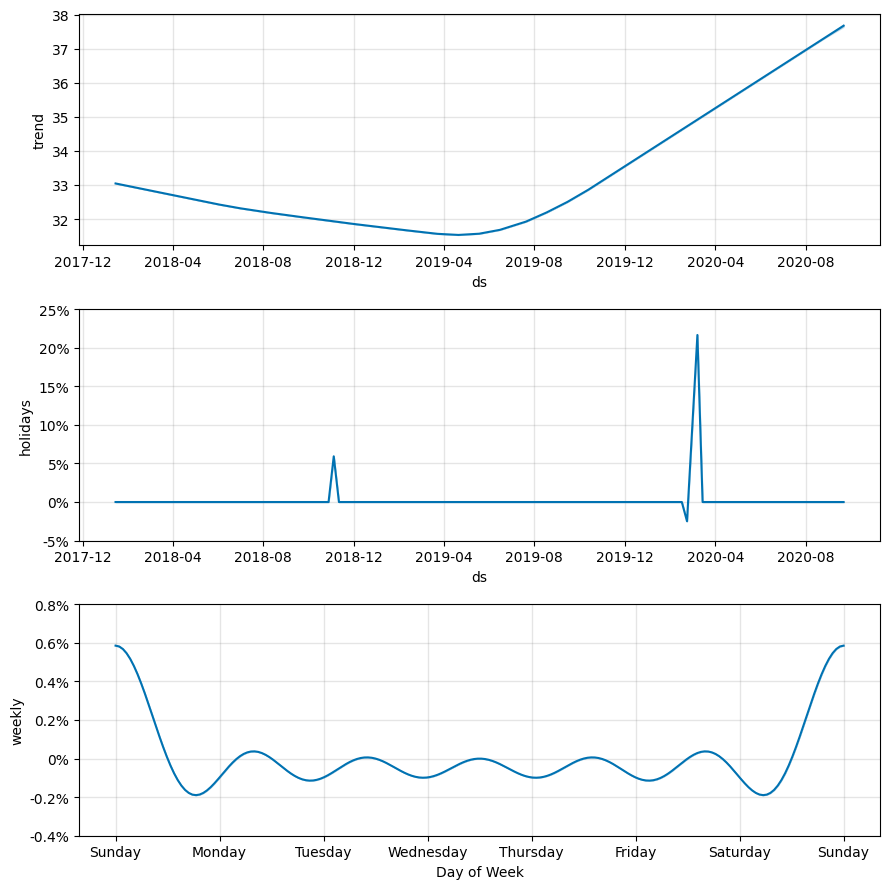

In [ ]:
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
from prophet.plot import add_changepoints_to_plot
%config InlineBackend.figure_format = 'retina'


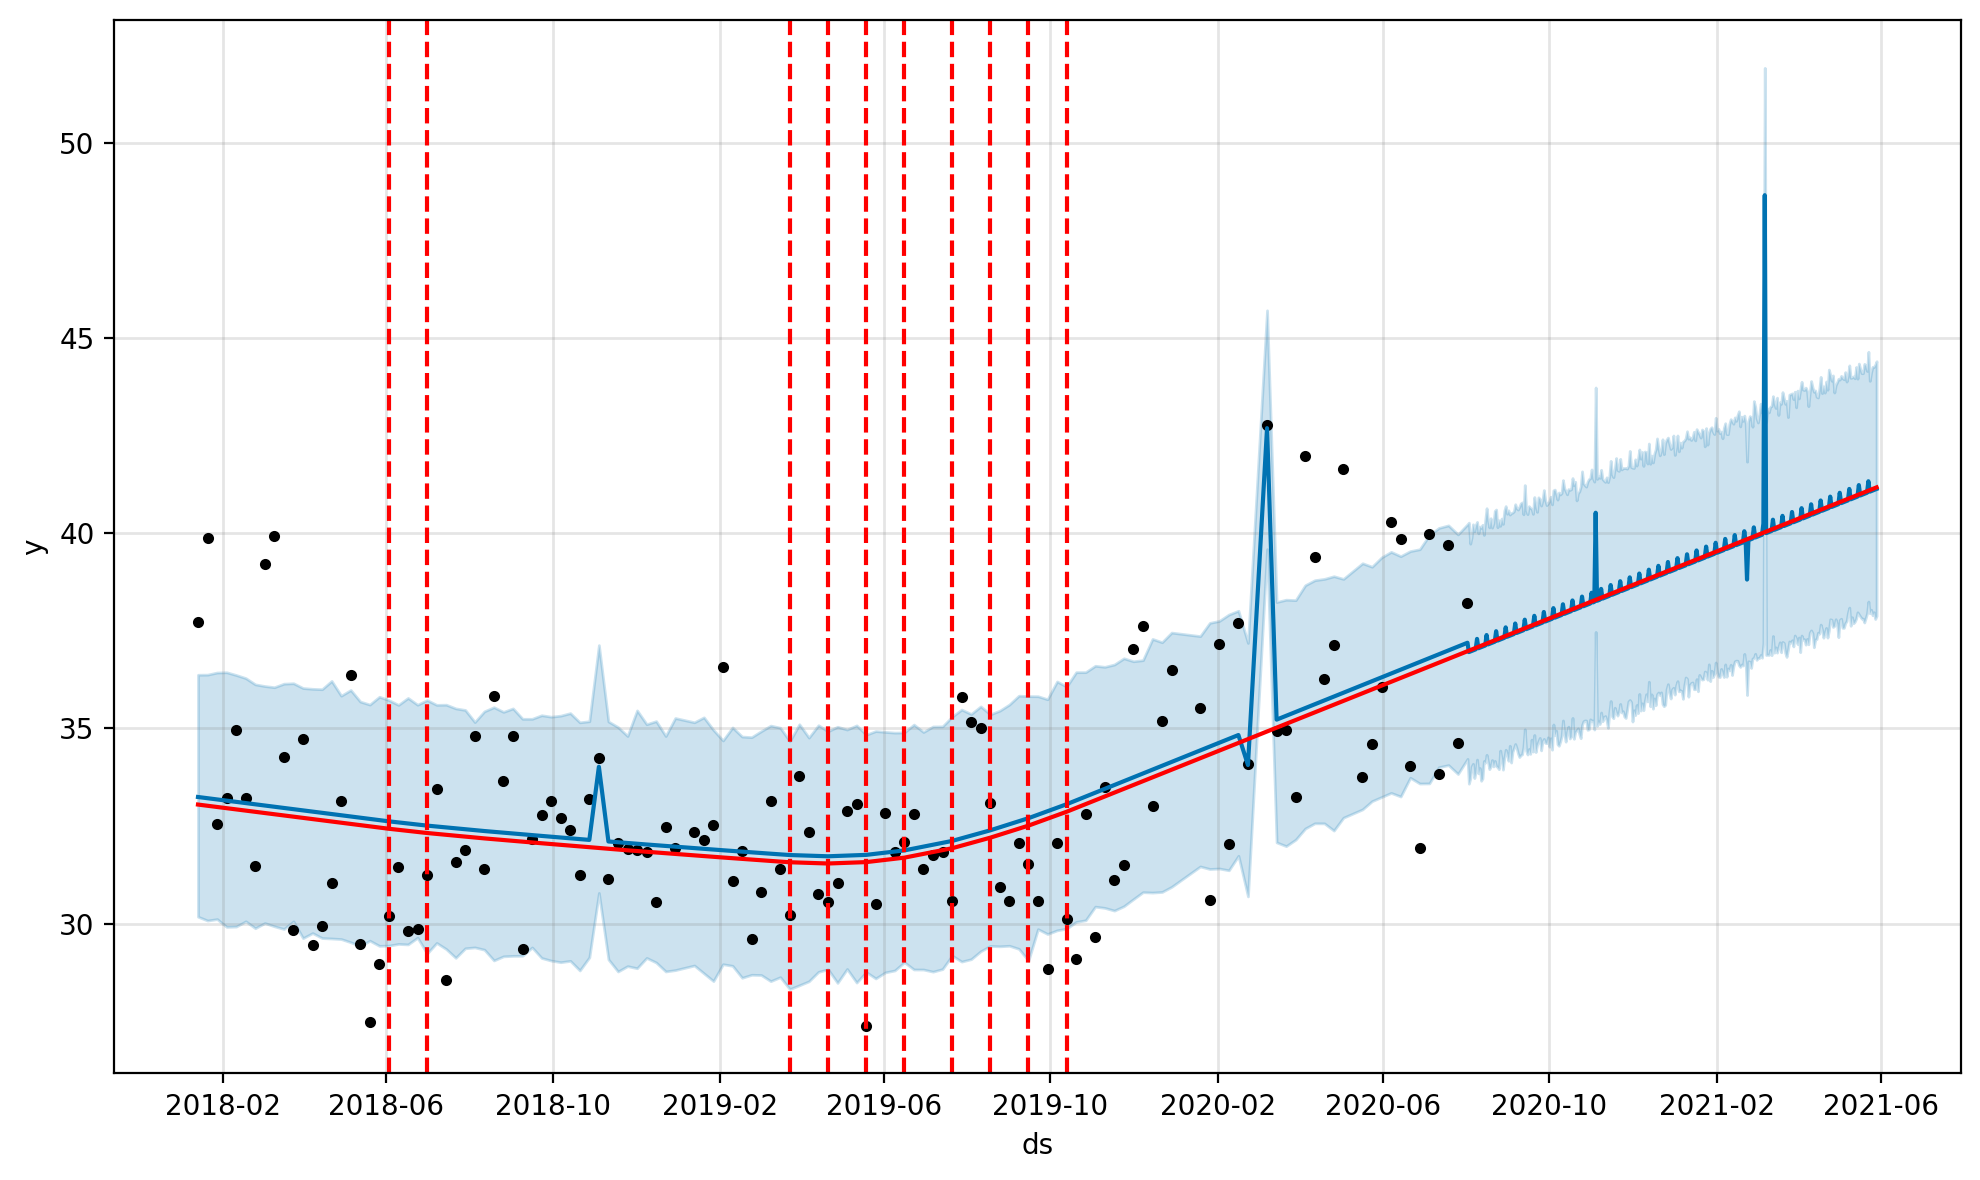

In [ ]:
fig = model.plot(forecast)
add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

Prophet определил, что 10 потенциальных точек изменения
действительно являются значимыми. Эти 10 точек обозначены на графике
вертикальными пунктирными линиями.
Глядя на первую точку изменения, трудно сказать, что тренд на самом деле
меняется, но со следующими точками ситуация намного яснее.
В каждой из этих точек изменения наклон тренда становится все сильнее, т. е.
становится более изогнутым.

## Попробуем перекрестную проверку

In [ ]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

In [ ]:
  # Создаем модель
model_2 = Prophet(weekly_seasonality=6, yearly_seasonality=False, seasonality_mode='multiplicative', seasonality_prior_scale=.01, holidays_prior_scale=5)
model_2.add_country_holidays(country_name='RU')
model_2.fit(df6)
# делаем предсказания
future_2 = model_2.make_future_dataframe(periods=300)
forecast_2 = model_2.predict(future_2)
  # Устанавливаем параметры для кросс-валидации
initial = '40 days'
period = '5 days'
horizon = '20 days'
  # Проводим кросс-валидацию
df_cv = cross_validation(model=model_2, initial=initial, period=period, horizon=horizon, parallel='processes')

# Печатаем результаты
print(df_cv.head())


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmq17ub88/plwoipdm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmq17ub88/gdr75wil.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62347', 'data', 'file=/tmp/tmpmq17ub88/plwoipdm.json', 'init=/tmp/tmpmq17ub88/gdr75wil.json', 'output', 'file=/tmp/tmpmq17ub88/prophet_modelb4am0emw/prophet_model-20240315124729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:47:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 175 forecasts with cutoffs between 2018-02-24 00:00:00 and 2020-07-13 00:00:00
INFO:prophet:Applying in parallel with <con

          ds       yhat  yhat_lower  yhat_upper          y     cutoff
0 2018-02-25  31.576589   29.120543   33.979412  31.479501 2018-02-24
1 2018-03-04  30.525536   28.053803   33.102035  39.215827 2018-02-24
2 2018-03-11  29.474483   27.009554   32.130425  39.920981 2018-02-24
3 2018-03-04  30.476648   28.198245   32.705678  39.215827 2018-03-01
4 2018-03-11  29.416519   27.123564   31.806663  39.920981 2018-03-01


In [ ]:
## вычисляем метрики
df_p = performance_metrics(df_cv)
df_p.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0  3 days   9.647850  3.106099  2.305776  0.066488  0.051695  0.068799   
1  4 days  10.682284  3.268376  2.523195  0.073219  0.059360  0.075173   
2  5 days   7.716925  2.777935  2.197268  0.065614  0.046225  0.066475   
3  6 days   8.040936  2.835654  2.146711  0.062614  0.046756  0.064430   
4  7 days   7.444327  2.728429  2.028596  0.058575  0.042556  0.060781   

   coverage  
0  0.712674  
1  0.640000  
2  0.736667  
3  0.797500  
4  0.784722

Здесь мы посмотрели как модель будет прогнозировать с учетом перекрестной проверки, если каждые 5 недель(т.е. месяц) будет обучаться и прогнозировать на 20  недель (т.е. 4 месяца). Процесс достаточно затратный, но мы видим как прогноз стал лучше. Теперь расхождение с фактическими данными составило не более 5,8%

Основные результаты анализа. Ориентируемся на метрику MAPE:

**Models:**
- `Prophet ETNA` базовая без преобразований: 9,58
- `Catboost ETNA` базовая без преобразований: 12,34
- `SMA ETNA` базовая без преобразований: 12,34
- `Prophet` базовая без преобразований: 7%
- `Prophet с перекрестной проверкой` базовая без преобразований: 5,8%


✅ Выводы:
- самая низкая ошибка у модели Prophet
